In [1]:
from spectral_cube import SpectralCube

In [2]:
from astropy import units as u

In [3]:
cube = SpectralCube.read('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw1_lines_cutout.fits')
cube

VaryingResolutionSpectralCube with shape=(1920, 1250, 1250) and unit=Jy / beam:
 n_x:   1250  type_x: RA---SIN  unit_x: deg    range:    83.809793 deg:   83.811187 deg
 n_y:   1250  type_y: DEC--SIN  unit_y: deg    range:    -5.375852 deg:   -5.374464 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231834857246.900 Hz:233708832546.243 Hz

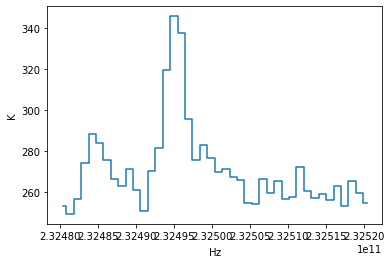

In [4]:
cube.spectral_slab(232.48*u.GHz, 232.52*u.GHz)[:, 640, 650].to(u.K).quicklook()

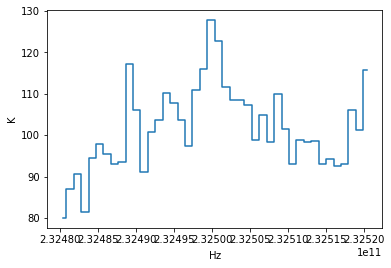

In [5]:
cube.spectral_slab(232.48*u.GHz, 232.52*u.GHz)[:, 660, 640].to(u.K).quicklook()

In [6]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b5613db9670>

In [7]:
from astropy.table import Table
from astropy import table

In [8]:
import pprint

In [9]:
import scipy, scipy.ndimage

In [10]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [11]:
import regions
from astropy import units as u, coordinates
cen = coordinates.SkyCoord(83.810486281, -5.37517214, unit=(u.deg, u.deg), frame='icrs')
reg = regions.Regions([regions.RectangleSkyRegion(cen, 0.53*u.arcsec, 0.34*u.arcsec, 52*u.deg)])
#    box(83.810486281, -5.375172145, 0.3368", 0.5281", 322.67123) # color=#2EE6D6 width=2

#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [12]:
regn = "co1"
cbflist = (glob.glob('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw*_lines_cutout_smaller.fits'))
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in cbflist]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:   -5.375086 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231834857246.900 Hz:233708832546.243 Hz,
 DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:   -5.375086 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 214277229834.040 Hz:216151205133.500 Hz,
 DaskSpectralCube with shape=(1920, 156, 148) and unit=Jy / beam and chunk size (640, 156, 148):
  n_x:    148  type_x: RA---SIN  unit_x: deg    range:    83.810404 deg:   83.810569 deg
  n_y:    156  type_y: DEC--SIN  unit_y: deg    range:    -5.375258 deg:

In [13]:
topright = coordinates.SkyCoord('5:35:14.5134090216', '-5:22:30.5431496522', frame='icrs', unit=(u.h, u.deg))
trv = 19.0*u.km/u.s
bottomleft = coordinates.SkyCoord('5:35:14.5211504272', '-5:22:30.7054489346', frame='icrs', unit=(u.h, u.deg))
blv = -7.6*u.km/u.s

In [14]:
import warnings
warnings.simplefilter('ignore')

In [15]:
paths.fpath("")

'/orange/adamginsburg/orion/2016.1.00165.S/figures/'

In [16]:
doplot = True

RMS=16.858215399752773


topright vel=19.0 km / s xmin/xmax: 859.5640041873293 GHz,859.449316694157 GHz, -0.7432977881196273 km / s, 8.45288333700922 km / s
23Na-37Clv=5-5 J=71-70: guesses=[25.0, 19.0, 2]
Line 23Na-37Clv=5-5 J=71-70 with frequency 859.561137 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 859.5844228133564 GHz,859.469732595825 GHz, -0.7744053955777861 km / s, 15.573972699401175 km / s
41K-37Clv=9-9 J=128-127: guesses=[25.0, 19.0, 2]
Line 41K-37Clv=9-9 J=128-127 with frequency 859.5815555579181 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 859.6791717515741 GHz,859.5644688921474 GHz, -0.766610326014054 km / s, 39.07816933193933 km / s
39K-35Clv=6-6 J=119-118: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 859.8136298245539 GHz,859.6989090250328 GHz, -0.533357312873152 km / s, 38.964690982746106 km / s
39K-37Clv=9-9 J=125-124: guesses=[132.09076819175874, 19.0, 2]
Line 39K-37Clv=9-9 J=125-124 with frequency 859.8107618045659 GHz has SNR=3.5
topright vel=19.0 km / s xmin/xmax: 860.1771582325841 GHz,860.0623889292151 GHz, -0.7877053998417988 km / s, 39.03400672903506 km / s
23Na-35Clv=4-4 J=69-68: guesses=[133.31390257347633, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.3517883240536 GHz,860.236995720631 GHz, -0.5082686474100343 km / s, 38.96507323079671 km / s
39K-37Clv=4-4 J=121-120: guesses=[43.26598022897334, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 860.4791826089922 GHz,860.3643730079624 GHz, -0.6948544426794191 km / s, 39.1128804418709 km / s
41K-37Clv=4-4 J=124-123: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.516717221697 GHz,860.4019026126043 GHz, -0.5467135385198899 km / s, 38.919062775146415 km / s
41K-37Clv=10-10 J=129-128: guesses=[37.8727482950638, 19.0, 2]
Line 41K-37Clv=10-10 J=129-128 with frequency 860.5138468564697 GHz has SNR=inf
topright vel=19.0 km / s xmin/xmax: 860.5330298545803 GHz,860.4182130689712 GHz, -0.6473767925410289 km / s, 39.157867151159536 km / s
41K-35Clv=1-1 J=118-117: guesses=[75.9359897923891, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.576612565016 GHz,860.4617899643754 GHz, -0.7737041271000621 km / s, 39.0295239351609 km / s
23Na-37Clv=3-3 J=70-69: guesses=[81.64719946271154, 19.0, 2]
Line 23Na-37Clv=3-3 J=70-69 with frequency 860.573742 GHz has SNR=11.8
topright vel=19.0 km / s xmin/xmax: 860.6102049833107 GHz,860.4953779005953 GHz, -0.6380967673769357 km / s, 39.16357764530051 km / s
39K-35Clv=2-2 J=116-115: guesses=[81.64719946271154, 19.0, 2]


Line 39K-35Clv=2-2 J=116-115 with frequency 860.6073343062428 GHz has SNR=11.7
topright vel=19.0 km / s xmin/xmax: 860.8379578418868 GHz,860.7231003712022 GHz, -0.5636958121132831 km / s, 38.887352978976 km / s
41K-35Clv=6-6 J=122-121: guesses=[25.0, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 860.8434099510188 GHz,860.7285517528856 GHz, -0.7055301119101899 km / s, 39.08536191213671 km / s
39K-37Clv=10-10 J=126-125: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 860.9539448236568 GHz,860.8390718773868 GHz, -0.641717674992897 km / s, 39.14406573527916 km / s
23Na-35Clv=2-2 J=68-67: guesses=[32.54439859288229, 19.0, 2]
Line 23Na-35Clv=2-2 J=68-67 with frequency 860.951073 GHz has SNR=0.4
topright vel=19.0 km / s xmin/xmax: 861.0239353752396 GHz,860.9090530904667 GHz, -0.7538310659613171 km / s, 39.028718254279525 km / s
39K-35Clv=7-7 J=120-119: guesses=[32.54439859288229, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 861.2397462746642 GHz,861.1248351952805 GHz, -0.7571309335795321 km / s, 39.01544960876021 km / s
39K-37Clv=0-0 J=118-117: guesses=[25.0, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 861.3786882404436 GHz,861.2637586227012 GHz, -0.6631432479903792 km / s, 39.103021903998865 km / s
23Na-37Clv=1-1 J=69-68: guesses=[38.099906343341985, 19.0, 2]


Line 23Na-37Clv=1-1 J=69-68 with frequency 861.375815 GHz has SNR=4.2


RMS=18.167749558388728
bottomleft vel=-7.6 km / s xmin/xmax: 859.6402713702889 GHz,859.5255838771167 GHz, -27.310043260714075 km / s, 8.45288333700922 km / s
23Na-37Clv=5-5 J=71-70: guesses=[25.0, -7.6, 2]
Line 23Na-37Clv=5-5 J=71-70 with frequency 859.561137 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 859.6606918080148 GHz,859.5460015904833 GHz, -27.340519799918596 km / s, 12.508651806592617 km / s
41K-37Clv=9-9 J=128-127: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 859.755449153093 GHz,859.6407462936662 GHz, -27.32979676464964 km / s, 12.514982893303738 km / s
39K-35Clv=6-6 J=119-118: guesses=[26.707473528789407, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 859.8899191562356 GHz,859.7751983567144 GHz, -27.09238978751369 km / s, 12.40565850810557 km / s
39K-37Clv=9-9 J=125-124: guesses=[51.23545998814404, -7.6, 2]


Line 39K-37Clv=9-9 J=125-124 with frequency 859.8107618045659 GHz has SNR=6.4
bottomleft vel=-7.6 km / s xmin/xmax: 860.2534798193248 GHz,860.1387105159556 GHz, -27.335513485759705 km / s, 12.486198643117156 km / s
23Na-35Clv=4-4 J=69-68: guesses=[133.1097044473179, -7.6, 2]
Line 23Na-35Clv=4-4 J=69-68 with frequency 860.174289 GHz has SNR=17.0
bottomleft vel=-7.6 km / s xmin/xmax: 860.4281254053299 GHz,860.3133328019071 GHz, -27.390975616188765 km / s, 12.42265369200252 km / s
39K-37Clv=4-4 J=121-120: guesses=[54.70635699404949, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 860.5555309936772 GHz,860.4407213926472 GHz, -27.23334436571297 km / s, 12.234153468542052 km / s
41K-37Clv=4-4 J=124-123: guesses=[50.22683808635169, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 860.5930689367439 GHz,860.4782543276509 GHz, -27.424268096965044 km / s, 12.38173042630183 km / s
41K-37Clv=10-10 J=129-128: guesses=[60.363213016794546, -7.6, 2]


Line 41K-37Clv=10-10 J=129-128 with frequency 860.5138468564697 GHz has SNR=3.0
bottomleft vel=-7.6 km / s xmin/xmax: 860.6093830170103 GHz,860.4945662314013 GHz, -27.184206088341405 km / s, 12.28082209515659 km / s
41K-35Clv=1-1 J=118-117: guesses=[73.76342685403387, -7.6, 2]
Line 41K-35Clv=1-1 J=118-117 with frequency 860.5301594349401 GHz has SNR=2.8
bottomleft vel=-7.6 km / s xmin/xmax: 860.652969594442 GHz,860.5381469938014 GHz, -27.309189501940708 km / s, 12.494038560320261 km / s
23Na-37Clv=3-3 J=70-69: guesses=[73.76342685403387, -7.6, 2]


Line 23Na-37Clv=3-3 J=70-69 with frequency 860.573742 GHz has SNR=9.7
bottomleft vel=-7.6 km / s xmin/xmax: 860.6865649933164 GHz,860.571737910601 GHz, -27.172546375828567 km / s, 12.288942785458476 km / s
39K-35Clv=2-2 J=116-115: guesses=[73.76342685403387, -7.6, 2]
Line 39K-35Clv=2-2 J=116-115 with frequency 860.6073343062428 GHz has SNR=9.5
bottomleft vel=-7.6 km / s xmin/xmax: 860.914338059892 GHz,860.7994805892074 GHz, -27.091125171638836 km / s, 12.359923619450448 km / s
41K-35Clv=6-6 J=122-121: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 860.9197906527774 GHz,860.8049324546441 GHz, -27.23279146127479 km / s, 12.558100562772111 km / s
39K-37Clv=10-10 J=126-125: guesses=[25.0, -7.6, 2]
Line 39K-37Clv=10-10 J=126-125 with frequency 860.8405384960654 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 861.0303353329264 GHz,860.9154623866563 GHz, -27.16557328184094 km / s, 12.280160697574097 km / s
23Na-35Clv=2-2 J=68-67: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 861.1003320946135 GHz,860.9854498098406 GHz, -27.275530612788543 km / s, 12.507018707452296 km / s
39K-35Clv=7-7 J=120-119: guesses=[45.799241634567245, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 861.3161621424546 GHz,861.2012510630707 GHz, -27.272184628472694 km / s, 12.50039591386705 km / s
39K-37Clv=0-0 J=118-117: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 861.4551164362423 GHz,861.3401868184999 GHz, -4.741724289220045 km / s, 12.252363382570229 km / s
23Na-37Clv=1-1 J=69-68: guesses=[25.0, -7.6, 2]
Line 23Na-37Clv=1-1 J=69-68 with frequency 861.375815 GHz has SNR=0.0


RMS=18.59363171075338
topright vel=19.0 km / s xmin/xmax: 85.98195580397623 GHz,85.97048364492679 GHz, 1.3795518754484508 km / s, 38.83338773475346 km / s
23Na-37Clv=5-5 J=7-6: guesses=[89.12217024102766, 19.0, 2]
Line 23Na-37Clv=5-5 J=7-6 with frequency 85.981669 GHz has SNR=5.0
topright vel=19.0 km / s xmin/xmax: 86.62137393683845 GHz,86.60981646330121 GHz, 4.002054923265986 km / s, 37.79965552147739 km / s
23Na-37Clv=4-4 J=7-6: guesses=[137.32126289143224, 19.0, 2]


Line 23Na-37Clv=4-4 J=7-6 with frequency 86.62108500000001 GHz has SNR=8.8
topright vel=19.0 km / s xmin/xmax: 87.16949576516994 GHz,87.15786515837196 GHz, 1.5904324908814953 km / s, 38.534021888480034 km / s
23Na-35Clv=6-6 J=7-6: guesses=[54.578034270796394, 19.0, 2]
Line 23Na-35Clv=6-6 J=7-6 with frequency 87.169205 GHz has SNR=0.7
topright vel=19.0 km / s xmin/xmax: 87.2649270834935 GHz,87.25328374375346 GHz, 4.017181752310406 km / s, 37.565534996042736 km / s
23Na-37Clv=3-3 J=7-6: guesses=[98.73677973296566, 19.0, 2]


Line 23Na-37Clv=3-3 J=7-6 with frequency 87.264636 GHz has SNR=5.3


RMS=28.733005835106532
bottomleft vel=-7.6 km / s xmin/xmax: 85.98958478974411 GHz,85.97811263069468 GHz, -25.85960147677337 km / s, 11.594234382531635 km / s
23Na-37Clv=5-5 J=7-6: guesses=[64.35969184595226, -7.6, 2]


Line 23Na-37Clv=5-5 J=7-6 with frequency 85.981669 GHz has SNR=4.2
bottomleft vel=-7.6 km / s xmin/xmax: 86.62905965674071 GHz,86.61750218320348 GHz, -23.03602555530314 km / s, 10.761575042908268 km / s
23Na-37Clv=4-4 J=7-6: guesses=[52.35297639101131, -7.6, 2]
Line 23Na-37Clv=4-4 J=7-6 with frequency 86.62108500000001 GHz has SNR=2.0
bottomleft vel=-7.6 km / s xmin/xmax: 87.1772301186906 GHz,87.16559951189262 GHz, -25.27763252555381 km / s, 11.665956872044733 km / s
23Na-35Clv=6-6 J=7-6: guesses=[40.756916663162045, -7.6, 2]


Line 23Na-35Clv=6-6 J=7-6 with frequency 87.169205 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 87.27266990442062 GHz,87.26102656468059 GHz, -22.821500842675462 km / s, 10.726852401056874 km / s
23Na-37Clv=3-3 J=7-6: guesses=[52.739921524047425, -7.6, 2]
Line 23Na-37Clv=3-3 J=7-6 with frequency 87.264636 GHz has SNR=0.2


RMS=18.70078929387851
topright vel=19.0 km / s xmin/xmax: 229.2468106824991 GHz,229.21622338253445 GHz, -0.0035994128585343996 km / s, 39.58493557132419 km / s
23Na-37Clv=0-0 J=18-17: guesses=[125.79217561106465, 19.0, 2]
Line 23Na-37Clv=0-0 J=18-17 with frequency 229.246046 GHz has SNR=11.2
topright vel=19.0 km / s xmin/xmax: 229.29293492734436 GHz,229.26234147324342 GHz, 0.2929778028824799 km / s, 38.59675658682179 km / s
39K-35Clv=6-6 J=31-30: guesses=[42.378212438935904, 19.0, 2]


Line 39K-35Clv=6-6 J=31-30 with frequency 229.29217009099185 GHz has SNR=2.8
topright vel=19.0 km / s xmin/xmax: 229.68303532325 GHz,229.65238981992846 GHz, 0.8937639132801588 km / s, 39.13248643719892 km / s
41K-35Clv=2-2 J=31-30: guesses=[42.4516092773647, 19.0, 2]
Line 41K-35Clv=2-2 J=31-30 with frequency 229.682269185667 GHz has SNR=3.0
topright vel=19.0 km / s xmin/xmax: 229.81957127230814 GHz,229.7889075516512 GHz, 0.6587610690692415 km / s, 38.874765944348816 km / s
39K-37Clv=1-1 J=31-30: guesses=[75.7834009270256, 19.0, 2]


Line 39K-37Clv=1-1 J=31-30 with frequency 229.81880467929173 GHz has SNR=5.9
topright vel=19.0 km / s xmin/xmax: 230.07148739934638 GHz,230.0407900667316 GHz, 0.6171679923815065 km / s, 38.791328360773775 km / s
39K-37Clv=6-6 J=32-31: guesses=[30.489542893604884, 19.0, 2]
Line 39K-37Clv=6-6 J=32-31 with frequency 230.07071996603105 GHz has SNR=1.2
topright vel=19.0 km / s xmin/xmax: 230.32140733781432 GHz,230.29067665958348 GHz, 0.5195613808781359 km / s, 38.65229926961206 km / s
39K-35Clv=0-0 J=30-29: guesses=[113.67346044030957, 19.0, 2]


Line 39K-35Clv=0-0 J=30-29 with frequency 230.32063907085856 GHz has SNR=9.7
topright vel=19.0 km / s xmin/xmax: 230.72476344491233 GHz,230.69397894881507 GHz, 0.5768761704556943 km / s, 38.64294989848949 km / s
39K-35Clv=5-5 J=31-30: guesses=[60.76032498478991, 19.0, 2]
Line 39K-35Clv=5-5 J=31-30 with frequency 230.7239938325099 GHz has SNR=4.6
topright vel=19.0 km / s xmin/xmax: 230.7799367964403 GHz,230.74914493882795 GHz, -0.05909889003261134 km / s, 39.266440022483536 km / s
23Na-35Clv=2-2 J=18-17: guesses=[116.74223756050685, 19.0, 2]


Line 23Na-35Clv=2-2 J=18-17 with frequency 230.779167 GHz has SNR=12.0


RMS=15.97482503438239
bottomleft vel=-7.6 km / s xmin/xmax: 229.26715123697562 GHz,229.23656393701097 GHz, -26.82163924085328 km / s, 12.76689574332944 km / s
23Na-37Clv=0-0 J=18-17: guesses=[171.03684788569322, -7.6, 2]
Line 23Na-37Clv=0-0 J=18-17 with frequency 229.246046 GHz has SNR=15.4
bottomleft vel=-7.6 km / s xmin/xmax: 229.3132795743215 GHz,229.28268612022057 GHz, -26.519667345875035 km / s, 11.784111438064272 km / s
39K-35Clv=6-6 J=31-30: guesses=[70.20671074100436, -7.6, 2]


Line 39K-35Clv=6-6 J=31-30 with frequency 229.29217009099185 GHz has SNR=5.0
bottomleft vel=-7.6 km / s xmin/xmax: 229.70341458295889 GHz,229.6727690796373 GHz, -25.873341853462975 km / s, 12.365380670455787 km / s
41K-35Clv=2-2 J=31-30: guesses=[43.95406691263309, -7.6, 2]
Line 41K-35Clv=2-2 J=31-30 with frequency 229.682269185667 GHz has SNR=3.7
bottomleft vel=-7.6 km / s xmin/xmax: 229.839962646545 GHz,229.80929892588807 GHz, -26.092442343626463 km / s, 12.123562531653116 km / s
39K-37Clv=1-1 J=31-30: guesses=[83.26952744820538, -7.6, 2]


Line 39K-37Clv=1-1 J=31-30 with frequency 229.81880467929173 GHz has SNR=6.2
bottomleft vel=-7.6 km / s xmin/xmax: 230.09190112553526 GHz,230.06120379292045 GHz, -26.10474426549308 km / s, 12.069416102899186 km / s
39K-37Clv=6-6 J=32-31: guesses=[27.383726453045007, -7.6, 2]
Line 39K-37Clv=6-6 J=32-31 with frequency 230.07071996603105 GHz has SNR=2.4
bottomleft vel=-7.6 km / s xmin/xmax: 230.34184323883784 GHz,230.311112560607 GHz, -26.173355141235607 km / s, 11.95938274749831 km / s
39K-35Clv=0-0 J=30-29: guesses=[130.54977031683455, -7.6, 2]


Line 39K-35Clv=0-0 J=30-29 with frequency 230.32063907085856 GHz has SNR=11.5
bottomleft vel=-7.6 km / s xmin/xmax: 230.74523513481702 GHz,230.71445063871977 GHz, -26.069375439167963 km / s, 11.996698288865833 km / s
39K-35Clv=5-5 J=31-30: guesses=[55.15024922210272, -7.6, 2]
Line 39K-35Clv=5-5 J=31-30 with frequency 230.7239938325099 GHz has SNR=4.2
bottomleft vel=-7.6 km / s xmin/xmax: 230.80041338175252 GHz,230.76962152414018 GHz, -26.698980088833874 km / s, 12.626558823682274 km / s
23Na-35Clv=2-2 J=18-17: guesses=[160.50544816815793, -7.6, 2]


Line 23Na-35Clv=2-2 J=18-17 with frequency 230.779167 GHz has SNR=15.9


RMS=76.39570991558568
topright vel=19.0 km / s xmin/xmax: 344.7159065803974 GHz,344.66991279402464 GHz, -0.03988043402685726 km / s, 39.02789086305718 km / s
39K-35Clv=7-7 J=47-46: guesses=[134.4431141965546, 19.0, 2]
Line 39K-35Clv=7-7 J=47-46 with frequency 344.7147567357381 GHz has SNR=2.6
topright vel=19.0 km / s xmin/xmax: 344.82175843736854 GHz,344.77575052769134 GHz, -0.5561206789290732 km / s, 39.34869642852553 km / s
39K-35Clv=0-0 J=45-44: guesses=[171.49266101759787, 19.0, 2]


Line 39K-35Clv=0-0 J=45-44 with frequency 344.82060823962667 GHz has SNR=3.1
topright vel=19.0 km / s xmin/xmax: 345.76319033801025 GHz,345.7170568176 GHz, -0.5349649402800714 km / s, 39.26120072924239 km / s
23Na-35Clv=2-2 J=27-26: guesses=[180.5041405103073, 19.0, 2]


Line 23Na-35Clv=2-2 J=27-26 with frequency 345.762037 GHz has SNR=1.5


RMS=74.93640822069803
bottomleft vel=-7.6 km / s xmin/xmax: 344.74649244833535 GHz,344.70049866196257 GHz, -26.368161090757408 km / s, 12.699610206326634 km / s
39K-35Clv=7-7 J=47-46: guesses=[138.66658219309534, -7.6, 2]


Line 39K-35Clv=7-7 J=47-46 with frequency 344.7147567357381 GHz has SNR=1.7
bottomleft vel=-7.6 km / s xmin/xmax: 344.8523536973039 GHz,344.80634578762675 GHz, -26.8763191966119 km / s, 12.17945924898197 km / s
39K-35Clv=0-0 J=45-44: guesses=[156.33786757332513, -7.6, 2]


Line 39K-35Clv=0-0 J=45-44 with frequency 344.82060823962667 GHz has SNR=1.8
bottomleft vel=-7.6 km / s xmin/xmax: 345.7938691290831 GHz,345.7477356086728 GHz, -26.78349974358212 km / s, 12.165938996801565 km / s
23Na-35Clv=2-2 J=27-26: guesses=[25.0, -7.6, 2]


RMS=9.335812958073154
topright vel=19.0 km / s xmin/xmax: 497.99375925025805 GHz,497.927314336807 GHz, -0.7954766441433438 km / s, 38.88740992413112 km / s
39K-37Clv=2-2 J=68-67: guesses=[25.0, 19.0, 2]


Line 39K-37Clv=2-2 J=68-67 with frequency 497.99209812742174 GHz has SNR=4.4
topright vel=19.0 km / s xmin/xmax: 498.28668709993514 GHz,498.2202031025292 GHz, -0.8206867194650903 km / s, 39.13264597100857 km / s
23Na-35Clv=2-2 J=39-38: guesses=[44.73116981751447, 19.0, 2]
Line 23Na-35Clv=2-2 J=39-38 with frequency 498.285025 GHz has SNR=11.0
topright vel=19.0 km / s xmin/xmax: 498.29360825189383 GHz,498.2271233310319 GHz, -0.7694320191863863 km / s, 38.88957530656425 km / s
41K-37Clv=5-5 J=71-70: guesses=[44.73116981751447, 19.0, 2]


Line 41K-37Clv=5-5 J=71-70 with frequency 498.2919461288723 GHz has SNR=11.0
RMS=9.355073258222829
bottomleft vel=-7.6 km / s xmin/xmax: 498.037945117703 GHz,497.9715002042519 GHz, -27.25073435635082 km / s, 12.43215221192365 km / s
39K-37Clv=2-2 J=68-67: guesses=[25.0, -7.6, 2]


Line 39K-37Clv=2-2 J=68-67 with frequency 497.99209812742174 GHz has SNR=0.9
bottomleft vel=-7.6 km / s xmin/xmax: 498.3308989582101 GHz,498.2644149608042 GHz, -27.26039217640483 km / s, 12.399166009004782 km / s
23Na-35Clv=2-2 J=39-38: guesses=[43.45857914226915, -7.6, 2]
Line 23Na-35Clv=2-2 J=39-38 with frequency 498.285025 GHz has SNR=11.1
bottomleft vel=-7.6 km / s xmin/xmax: 498.33782072426703 GHz,498.2713358034051 GHz, -27.208770236377955 km / s, 12.450237089409397 km / s
41K-37Clv=5-5 J=71-70: guesses=[43.45857914226915, -7.6, 2]


Line 41K-37Clv=5-5 J=71-70 with frequency 498.2919461288723 GHz has SNR=11.1


RMS=14.263015203330449
topright vel=19.0 km / s xmin/xmax: 839.6618887705563 GHz,839.5498567209751 GHz, -0.542523354318716 km / s, 29.44330027877 km / s
41K-35Clv=1-1 J=115-114: guesses=[141.70371115366095, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 840.0684615664069 GHz,839.9563752697719 GHz, -0.7759786786475893 km / s, 38.9534338694044 km / s
39K-37Clv=4-4 J=118-117: guesses=[26.10779918133379, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 840.2952729825332 GHz,840.1831564235412 GHz, -0.6871915652311557 km / s, 39.03149727103569 km / s
39K-37Clv=9-9 J=122-121: guesses=[47.84926625084043, 19.0, 2]


Line 39K-37Clv=9-9 J=122-121 with frequency 840.2924700685585 GHz has SNR=9.0
topright vel=19.0 km / s xmin/xmax: 840.3397389147624 GHz,840.2276164228947 GHz, -0.501467604193082 km / s, 38.866728432771204 km / s
39K-37Clv=0-0 J=115-114: guesses=[38.76131836347461, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 840.4577124558127 GHz,840.3455742233027 GHz, -0.5694754997603855 km / s, 39.14153670650081 km / s
23Na-37Clv=8-8 J=71-70: guesses=[28.753825843463083, 19.0, 2]


Line 23Na-37Clv=8-8 J=71-70 with frequency 840.454909 GHz has SNR=2.8
topright vel=19.0 km / s xmin/xmax: 840.5557275236802 GHz,840.4435762134907 GHz, -0.7898331177289399 km / s, 38.91654848828884 km / s
41K-37Clv=9-9 J=125-124: guesses=[33.38648239462853, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 840.588153766466 GHz,840.4759981297989 GHz, -0.7186199144627912 km / s, 38.98622999167992 km / s
39K-35Clv=7-7 J=117-116: guesses=[25.0, 19.0, 2]


Line 39K-35Clv=7-7 J=117-116 with frequency 840.5853498755494 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 840.7110525467991 GHz,840.5988805123384 GHz, -0.7714484177105885 km / s, 38.927597261626744 km / s
41K-37Clv=4-4 J=121-120: guesses=[199.34080168478468, 19.0, 2]
Line 41K-37Clv=4-4 J=121-120 with frequency 840.7082482459376 GHz has SNR=43.6
topright vel=19.0 km / s xmin/xmax: 840.7463039363881 GHz,840.6341271985041 GHz, -0.7375266915392141 km / s, 38.95985445889207 km / s
41K-35Clv=6-6 J=119-118: guesses=[199.34080168478468, 19.0, 2]


Line 41K-35Clv=6-6 J=119-118 with frequency 840.743499517941 GHz has SNR=47.1
topright vel=19.0 km / s xmin/xmax: 840.8725498395567 GHz,840.7603562572887 GHz, -0.6415159810918685 km / s, 39.049905132068936 km / s
23Na-35Clv=7-7 J=69-68: guesses=[169.40647936212287, 19.0, 2]
Line 23Na-35Clv=7-7 J=69-68 with frequency 840.869745 GHz has SNR=18.2
topright vel=19.0 km / s xmin/xmax: 841.1331090803486 GHz,841.0208807329135 GHz, -0.7067846164090668 km / s, 38.97234121739636 km / s
39K-35Clv=3-3 J=114-113: guesses=[122.28778815271662, 19.0, 2]


Line 39K-35Clv=3-3 J=114-113 with frequency 841.1303033716628 GHz has SNR=9.4
topright vel=19.0 km / s xmin/xmax: 841.2899733875106 GHz,841.177724110425 GHz, -0.4879025868847045 km / s, 38.835827192085794 km / s
41K-37Clv=0-0 J=118-117: guesses=[32.78725421556414, 19.0, 2]


Line 41K-37Clv=0-0 J=118-117 with frequency 841.2871671555833 GHz has SNR=2.3
topright vel=19.0 km / s xmin/xmax: 841.3693270775773 GHz,841.2570672127104 GHz, -0.7460641242765883 km / s, 38.92192162712436 km / s
41K-35Clv=2-2 J=116-115: guesses=[39.73994648925821, 19.0, 2]
Line 41K-35Clv=2-2 J=116-115 with frequency 841.3665205809557 GHz has SNR=2.5


RMS=16.511802237246886
bottomleft vel=-7.6 km / s xmin/xmax: 839.7363900835279 GHz,839.6243580339466 GHz, -27.390295676967913 km / s, 12.358354255265963 km / s
41K-35Clv=1-1 J=115-114: guesses=[115.3590326106682, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 840.1429989536692 GHz,840.0309126570343 GHz, -27.262253710682252 km / s, 12.467158837369743 km / s
39K-37Clv=4-4 J=118-117: guesses=[41.615793285014625, -7.6, 2]


Line 39K-37Clv=4-4 J=118-117 with frequency 840.0656594089911 GHz has SNR=3.7
bottomleft vel=-7.6 km / s xmin/xmax: 840.3698304942629 GHz,840.2577139352709 GHz, -27.166317456075713 km / s, 12.552371380191126 km / s
39K-37Clv=9-9 J=122-121: guesses=[25.84172679982629, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 840.4143003718544 GHz,840.3021778799867 GHz, -27.32758348778821 km / s, 12.389003664547435 km / s
39K-37Clv=0-0 J=115-114: guesses=[26.469605901263485, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 840.532284380432 GHz,840.420146147922 GHz, -27.391825849603475 km / s, 12.319186356657722 km / s
23Na-37Clv=8-8 J=71-70: guesses=[32.06246522778848, -7.6, 2]
Line 23Na-37Clv=8-8 J=71-70 with frequency 840.454909 GHz has SNR=3.5
bottomleft vel=-7.6 km / s xmin/xmax: 840.6303081449561 GHz,840.5181568347666 GHz, -27.260754188407457 km / s, 12.44562741761032 km / s
41K-37Clv=9-9 J=125-124: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 840.6627372648496 GHz,840.5505816281825 GHz, -27.188519851891268 km / s, 12.516330054251446 km / s
39K-35Clv=7-7 J=117-116: guesses=[33.9087480705178, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 840.7856469497156 GHz,840.6734749152548 GHz, -27.23747887060214 km / s, 12.461566808735189 km / s
41K-37Clv=4-4 J=121-120: guesses=[179.04125494718218, -7.6, 2]


Line 41K-37Clv=4-4 J=121-120 with frequency 840.7082482459376 GHz has SNR=21.6
bottomleft vel=-7.6 km / s xmin/xmax: 840.8209014670811 GHz,840.708724729197 GHz, -27.2024474584934 km / s, 12.494933691937877 km / s
41K-35Clv=6-6 J=119-118: guesses=[181.26709595427297, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 840.947158571765 GHz,840.8349649894968 GHz, -27.10246338986574 km / s, 12.240787362653306 km / s
23Na-35Clv=7-7 J=69-68: guesses=[129.92399503027468, -7.6, 2]


Line 23Na-35Clv=7-7 J=69-68 with frequency 840.869745 GHz has SNR=6.3
bottomleft vel=-7.6 km / s xmin/xmax: 841.207740931393 GHz,841.0955125839578 GHz, -27.159535172279355 km / s, 12.519590661526077 km / s
39K-35Clv=3-3 J=114-113: guesses=[40.669446566507425, -7.6, 2]
Line 39K-35Clv=3-3 J=114-113 with frequency 841.1303033716628 GHz has SNR=1.7
bottomleft vel=-7.6 km / s xmin/xmax: 841.3646191567724 GHz,841.2523698796869 GHz, -27.283718453970796 km / s, 12.388008933663157 km / s
41K-37Clv=0-0 J=118-117: guesses=[28.108402304075934, -7.6, 2]


Line 41K-37Clv=0-0 J=118-117 with frequency 841.2871671555833 GHz has SNR=1.8
bottomleft vel=-7.6 km / s xmin/xmax: 841.4439798877139 GHz,841.331720022847 GHz, -22.31988093644202 km / s, 12.47659779285706 km / s
41K-35Clv=2-2 J=116-115: guesses=[30.98986845258036, -7.6, 2]


RMS=27.70456711850454
topright vel=19.0 km / s xmin/xmax: 87.82548295330038 GHz,87.8137648212852 GHz, 0.7587061113404567 km / s, 37.426355992144515 km / s
23Na-35Clv=5-5 J=7-6: guesses=[109.98655439642611, 19.0, 2]
Line 23Na-35Clv=5-5 J=7-6 with frequency 87.82519 GHz has SNR=5.8
topright vel=19.0 km / s xmin/xmax: 87.91261524394145 GHz,87.90088548628357 GHz, 1.5088321104351463 km / s, 38.14013980851976 km / s
23Na-37Clv=2-2 J=7-6: guesses=[155.5912189512353, 19.0, 2]


Line 23Na-37Clv=2-2 J=7-6 with frequency 87.912322 GHz has SNR=6.3
topright vel=19.0 km / s xmin/xmax: 88.00552155018985 GHz,87.99377939649015 GHz, 1.9669969746492568 km / s, 38.55963346857157 km / s
39K-37Clv=3-3 J=12-11: guesses=[65.49220459795552, 19.0, 2]
Line 39K-37Clv=3-3 J=12-11 with frequency 88.00522799634737 GHz has SNR=4.2
topright vel=19.0 km / s xmin/xmax: 88.48578515582412 GHz,88.47397892286011 GHz, 1.2980516121253631 km / s, 37.69207867390796 km / s
23Na-35Clv=4-4 J=7-6: guesses=[87.48338838938776, 19.0, 2]


Line 23Na-35Clv=4-4 J=7-6 with frequency 88.48549000000001 GHz has SNR=3.5
topright vel=19.0 km / s xmin/xmax: 88.54337014513831 GHz,88.531556228886 GHz, 1.1925959985115249 km / s, 37.562953872459744 km / s
39K-37Clv=2-2 J=12-11: guesses=[31.114138743574987, 19.0, 2]
Line 39K-37Clv=2-2 J=12-11 with frequency 88.54307479723201 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 88.56444141819226 GHz,88.55262469050129 GHz, 3.10120571458375 km / s, 39.46291034430031 km / s
23Na-37Clv=1-1 J=7-6: guesses=[107.8790485556886, 19.0, 2]


Line 23Na-37Clv=1-1 J=7-6 with frequency 88.564146 GHz has SNR=4.3
topright vel=19.0 km / s xmin/xmax: 89.03158962440875 GHz,89.0197105673782 GHz, 1.0151927423083371 km / s, 40.47437272913351 km / s
41K-35Clv=2-2 J=12-11: guesses=[25.0, 19.0, 2]
Line 41K-35Clv=2-2 J=12-11 with frequency 89.03129264798301 GHz has SNR=inf
topright vel=19.0 km / s xmin/xmax: 89.08321644877591 GHz,89.07133050342634 GHz, 3.8640823183501776 km / s, 40.0140350021522 km / s
39K-37Clv=1-1 J=12-11: guesses=[57.607268538832265, 19.0, 2]


Line 39K-37Clv=1-1 J=12-11 with frequency 89.08291930014218 GHz has SNR=1.9
topright vel=19.0 km / s xmin/xmax: 89.15040537275111 GHz,89.13851046270638 GHz, 3.2142850287419855 km / s, 39.33699300835648 km / s
23Na-35Clv=3-3 J=7-6: guesses=[111.66828923519311, 19.0, 2]
Line 23Na-35Clv=3-3 J=7-6 with frequency 89.15010799999999 GHz has SNR=4.5
topright vel=19.0 km / s xmin/xmax: 89.22040560624598 GHz,89.20850135640659 GHz, 2.1678421541577793 km / s, 38.26220910600112 km / s
23Na-37Clv=0-0 J=7-6: guesses=[119.2583446648329, 19.0, 2]


Line 23Na-37Clv=0-0 J=7-6 with frequency 89.220108 GHz has SNR=5.1


RMS=14.869109495583636
bottomleft vel=-7.6 km / s xmin/xmax: 87.83327551109048 GHz,87.82155737907529 GHz, -25.9086756201534 km / s, 10.758974260650653 km / s
23Na-35Clv=5-5 J=7-6: guesses=[66.61497081791208, -7.6, 2]
Line 23Na-35Clv=5-5 J=7-6 with frequency 87.82519 GHz has SNR=4.5
bottomleft vel=-7.6 km / s xmin/xmax: 87.92041553278393 GHz,87.90868577512606 GHz, -25.1321189427173 km / s, 11.499188755367314 km / s
23Na-37Clv=2-2 J=7-6: guesses=[86.06280919514228, -7.6, 2]


Line 23Na-37Clv=2-2 J=7-6 with frequency 87.912322 GHz has SNR=6.1
bottomleft vel=-7.6 km / s xmin/xmax: 88.01333008240017 GHz,88.00158792870046 GHz, -24.645829566385146 km / s, 11.946806927537159 km / s
39K-37Clv=3-3 J=12-11: guesses=[39.43040764536733, -7.6, 2]
Line 39K-37Clv=3-3 J=12-11 with frequency 88.00522799634737 GHz has SNR=3.3
bottomleft vel=-7.6 km / s xmin/xmax: 88.49363630074518 GHz,88.48183006778117 GHz, -25.170331705534707 km / s, 11.223695356247887 km / s
23Na-35Clv=4-4 J=7-6: guesses=[101.22727829470752, -7.6, 2]


Line 23Na-35Clv=4-4 J=7-6 with frequency 88.48549000000001 GHz has SNR=7.5
bottomleft vel=-7.6 km / s xmin/xmax: 88.55122639944611 GHz,88.53941248319379 GHz, -25.25857336435991 km / s, 11.111784509588313 km / s
39K-37Clv=2-2 J=12-11: guesses=[39.1813582636949, -7.6, 2]
Line 39K-37Clv=2-2 J=12-11 with frequency 88.54307479723201 GHz has SNR=2.6
bottomleft vel=-7.6 km / s xmin/xmax: 88.57229954210679 GHz,88.56048281441579 GHz, -23.34367037975557 km / s, 13.018034249960994 km / s
23Na-37Clv=1-1 J=7-6: guesses=[89.55712844174602, -7.6, 2]


Line 23Na-37Clv=1-1 J=7-6 with frequency 88.564146 GHz has SNR=7.3
bottomleft vel=-7.6 km / s xmin/xmax: 89.03948919733409 GHz,89.02761014030354 GHz, -25.290927248908446 km / s, 10.879987739014629 km / s
41K-35Clv=2-2 J=12-11: guesses=[25.0, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 89.09112060243339 GHz,89.07923465708382 GHz, -25.71315169566966 km / s, 13.723160323023455 km / s
39K-37Clv=1-1 J=12-11: guesses=[36.77643135896177, -7.6, 2]


Line 39K-37Clv=1-1 J=12-11 with frequency 89.08291930014218 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 89.15831548793085 GHz,89.14642057788613 GHz, -23.056775320068557 km / s, 13.06593265954594 km / s
23Na-35Clv=3-3 J=7-6: guesses=[92.81727448754364, -7.6, 2]
Line 23Na-35Clv=3-3 J=7-6 with frequency 89.15010799999999 GHz has SNR=5.9
bottomleft vel=-7.6 km / s xmin/xmax: 89.22832193238918 GHz,89.21641768254979 GHz, -24.082606538091923 km / s, 12.011760413751418 km / s
23Na-37Clv=0-0 J=7-6: guesses=[137.07809384583032, -7.6, 2]


Line 23Na-37Clv=0-0 J=7-6 with frequency 89.220108 GHz has SNR=9.2


RMS=21.614886957293976
topright vel=19.0 km / s xmin/xmax: 232.1626208652445 GHz,232.1316445227434 GHz, -0.19476718602376641 km / s, 38.896561775084926 km / s
39K-35Clv=4-4 J=31-30: guesses=[56.43038834931919, 19.0, 2]
Line 39K-35Clv=4-4 J=31-30 with frequency 232.16184645668199 GHz has SNR=4.2
topright vel=19.0 km / s xmin/xmax: 232.51075256980104 GHz,232.47972977776004 GHz, 0.4285805938079791 km / s, 39.461379225311696 km / s
23Na-35Clv=1-1 J=18-17: guesses=[155.9887343873388, 19.0, 2]


Line 23Na-35Clv=1-1 J=18-17 with frequency 232.50997700000002 GHz has SNR=13.3
topright vel=19.0 km / s xmin/xmax: 232.9083295885518 GHz,232.87725374972035 GHz, 0.5887001842132582 km / s, 39.55486940945733 km / s
39K-37Clv=4-4 J=32-31: guesses=[45.72860671401427, 19.0, 2]
Line 39K-37Clv=4-4 J=32-31 with frequency 232.90755269258102 GHz has SNR=2.8
topright vel=19.0 km / s xmin/xmax: 233.1699797687389 GHz,233.1388690191816 GHz, 0.507398862260728 km / s, 39.42984245348837 km / s
23Na-37Clv=5-5 J=19-18: guesses=[63.2082096335444, 19.0, 2]


Line 23Na-37Clv=5-5 J=19-18 with frequency 233.16920199999998 GHz has SNR=3.3
topright vel=19.0 km / s xmin/xmax: 233.60647720897083 GHz,233.57530821965838 GHz, 0.4856091517966922 km / s, 39.33532553443779 km / s
39K-35Clv=3-3 J=31-30: guesses=[52.488339792298476, 19.0, 2]
Line 39K-35Clv=3-3 J=31-30 with frequency 233.60569798423805 GHz has SNR=3.4


RMS=17.801370916580023
bottomleft vel=-7.6 km / s xmin/xmax: 232.18322013300778 GHz,232.15224379050665 GHz, -26.675990030645785 km / s, 12.415338930462909 km / s
39K-35Clv=4-4 J=31-30: guesses=[71.95065043055476, -7.6, 2]
Line 39K-35Clv=4-4 J=31-30 with frequency 232.16184645668199 GHz has SNR=4.9
bottomleft vel=-7.6 km / s xmin/xmax: 232.53138272650833 GHz,232.50035993446733 GHz, -26.012992672694537 km / s, 13.01980595880918 km / s
23Na-35Clv=1-1 J=18-17: guesses=[171.2158175860623, -7.6, 2]


Line 23Na-35Clv=1-1 J=18-17 with frequency 232.50997700000002 GHz has SNR=15.7
bottomleft vel=-7.6 km / s xmin/xmax: 232.92899502137473 GHz,232.8979191825433 GHz, -25.807737032887562 km / s, 11.901458991542182 km / s
39K-37Clv=4-4 J=32-31: guesses=[39.9531120899242, -7.6, 2]
Line 39K-37Clv=4-4 J=32-31 with frequency 232.90755269258102 GHz has SNR=3.6
bottomleft vel=-7.6 km / s xmin/xmax: 233.19066841719447 GHz,233.15955766763722 GHz, -25.859417764054772 km / s, 11.807463130681656 km / s
23Na-37Clv=5-5 J=19-18: guesses=[112.80572192202787, -7.6, 2]


Line 23Na-37Clv=5-5 J=19-18 with frequency 233.16920199999998 GHz has SNR=7.6
bottomleft vel=-7.6 km / s xmin/xmax: 233.62720458686366 GHz,233.59603559755115 GHz, -25.831940655798896 km / s, 13.017775726842208 km / s
39K-35Clv=3-3 J=31-30: guesses=[62.21113220886428, -7.6, 2]
Line 39K-35Clv=3-3 J=31-30 with frequency 233.60569798423805 GHz has SNR=5.3


RMS=81.75648416134824
topright vel=19.0 km / s xmin/xmax: 346.8760511216011 GHz,346.829769117526 GHz, -0.004377184705357166 km / s, 38.820102507356935 km / s
39K-35Clv=6-6 J=47-46: guesses=[130.25244945842297, 19.0, 2]


Line 39K-35Clv=6-6 J=47-46 with frequency 346.8748940714992 GHz has SNR=1.4
topright vel=19.0 km / s xmin/xmax: 347.71381066304497 GHz,347.6674168807413 GHz, -0.11968455862389932 km / s, 38.611253901234825 km / s
39K-37Clv=1-1 J=47-46: guesses=[184.94375673571318, 19.0, 2]
Line 39K-37Clv=1-1 J=47-46 with frequency 347.71265081848736 GHz has SNR=3.2


RMS=77.41951165705336
bottomleft vel=-7.6 km / s xmin/xmax: 346.9068286543111 GHz,346.8605466502359 GHz, -27.012710883531305 km / s, 12.655779236619304 km / s
39K-35Clv=6-6 J=47-46: guesses=[101.25028916952348, -7.6, 2]


Line 39K-35Clv=6-6 J=47-46 with frequency 346.8748940714992 GHz has SNR=1.7
bottomleft vel=-7.6 km / s xmin/xmax: 347.7446625282769 GHz,347.6982687459732 GHz, -27.062946095916928 km / s, 12.509969286982209 km / s
39K-37Clv=1-1 J=47-46: guesses=[153.33286566099633, -7.6, 2]
Line 39K-37Clv=1-1 J=47-46 with frequency 347.71265081848736 GHz has SNR=1.5


RMS=7.1094172750694975
topright vel=19.0 km / s xmin/xmax: 495.82646989356124 GHz,495.76031415111095 GHz, -0.18822257945475732 km / s, 38.19195959107081 km / s
23Na-35Clv=6-6 J=40-39: guesses=[44.25132293276309, 19.0, 2]
Line 23Na-35Clv=6-6 J=40-39 with frequency 495.824816 GHz has SNR=2.3
topright vel=19.0 km / s xmin/xmax: 495.97221819933003 GHz,495.90604301038394 GHz, -0.6336249603500375 km / s, 38.91586031198357 km / s
39K-37Clv=5-5 J=69-68: guesses=[25.0, 19.0, 2]


Line 39K-37Clv=5-5 J=69-68 with frequency 495.9705638196064 GHz has SNR=2.0
topright vel=19.0 km / s xmin/xmax: 496.02091882371707 GHz,495.9547371368808 GHz, -0.12056976987730547 km / s, 38.834799562417786 km / s
41K-37Clv=8-8 J=72-71: guesses=[28.617413141794646, 19.0, 2]
Line 41K-37Clv=8-8 J=72-71 with frequency 496.0192642815462 GHz has SNR=8.0
topright vel=19.0 km / s xmin/xmax: 496.2095554946207 GHz,496.1433486389002 GHz, -0.6144919099957478 km / s, 38.916076822418916 km / s
39K-35Clv=0-0 J=65-64: guesses=[63.80699923747163, 19.0, 2]


Line 39K-35Clv=0-0 J=65-64 with frequency 496.2079003232277 GHz has SNR=4.3
topright vel=19.0 km / s xmin/xmax: 496.38108930216123 GHz,496.3148595595093 GHz, -0.2311705441747916 km / s, 39.28573765782272 km / s
41K-37Clv=1-1 J=69-68: guesses=[39.387572069354334, 19.0, 2]
Line 41K-37Clv=1-1 J=69-68 with frequency 496.37943355859494 GHz has SNR=7.9
topright vel=19.0 km / s xmin/xmax: 496.4496703590622 GHz,496.3834314659696 GHz, -0.6872446993523219 km / s, 38.8242045175924 km / s
41K-35Clv=8-8 J=70-69: guesses=[44.196021257748704, 19.0, 2]


Line 41K-35Clv=8-8 J=70-69 with frequency 496.44801438673494 GHz has SNR=9.3
topright vel=19.0 km / s xmin/xmax: 496.4519389798946 GHz,496.3856997841107 GHz, -0.4967302354222276 km / s, 39.01453842729403 km / s
23Na-37Clv=3-3 J=40-39: guesses=[44.196021257748704, 19.0, 2]
Line 23Na-37Clv=3-3 J=40-39 with frequency 496.450283 GHz has SNR=9.3
topright vel=19.0 km / s xmin/xmax: 496.5061179924882 GHz,496.43987156785914 GHz, -0.2142472535777342 km / s, 39.29270991841385 km / s
41K-35Clv=1-1 J=67-66: guesses=[25.0, 19.0, 2]


Line 41K-35Clv=1-1 J=67-66 with frequency 496.5044618318725 GHz has SNR=inf
topright vel=19.0 km / s xmin/xmax: 496.6006733230659 GHz,496.5344142823736 GHz, -0.3179245298488505 km / s, 39.181510313647856 km / s
39K-35Clv=7-7 J=68-67: guesses=[25.0, 19.0, 2]
Line 39K-35Clv=7-7 J=68-67 with frequency 496.5990168470486 GHz has SNR=1.0
topright vel=19.0 km / s xmin/xmax: 496.6557440651395 GHz,496.5894776766228 GHz, -0.6762346962596024 km / s, 38.81882032637665 km / s
41K-37Clv=10-10 J=73-72: guesses=[25.0, 19.0, 2]


Line 41K-37Clv=10-10 J=73-72 with frequency 496.6540874054266 GHz has SNR=1.9
topright vel=19.0 km / s xmin/xmax: 496.82104187635133 GHz,496.75475343294227 GHz, -0.5204798546732636 km / s, 38.96143472986021 km / s
39K-37Clv=0-0 J=67-66: guesses=[27.690196677764135, 19.0, 2]
Line 39K-37Clv=0-0 J=67-66 with frequency 496.8193846652661 GHz has SNR=6.7
topright vel=19.0 km / s xmin/xmax: 496.86720770379293 GHz,496.8009131006995 GHz, -0.3592658138413386 km / s, 39.118980355414344 km / s
39K-37Clv=7-7 J=70-69: guesses=[25.0, 19.0, 2]


Line 39K-37Clv=7-7 J=70-69 with frequency 496.86555033871565 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 497.1884741507187 GHz,497.1221366825875 GHz, -0.3738465619547828 km / s, 39.078890094234815 km / s
41K-35Clv=10-10 J=71-70: guesses=[25.0, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 497.4000527824657 GHz,497.33368708441475 GHz, -0.5766335232343016 km / s, 38.85932115636784 km / s
41K-37Clv=3-3 J=70-69: guesses=[78.86719865135856, 19.0, 2]


Line 41K-37Clv=3-3 J=70-69 with frequency 497.3983936400145 GHz has SNR=51.4
topright vel=19.0 km / s xmin/xmax: 497.48444445543885 GHz,497.4180674974126 GHz, -0.33139841348010834 km / s, 39.09786647666672 km / s
39K-35Clv=9-9 J=69-68: guesses=[25.0, 19.0, 2]


Line 39K-35Clv=9-9 J=69-68 with frequency 497.4827850314882 GHz has SNR=2.9
topright vel=19.0 km / s xmin/xmax: 497.5187621340789 GHz,497.45238059720975 GHz, -0.24835056890563728 km / s, 39.178194582922764 km / s
39K-35Clv=2-2 J=66-65: guesses=[25.0, 19.0, 2]
Line 39K-35Clv=2-2 J=66-65 with frequency 497.51710259565715 GHz has SNR=4.7
topright vel=19.0 km / s xmin/xmax: 497.5273225669762 GHz,497.4609398879296 GHz, -0.38614260490937324 km / s, 39.03972417554355 km / s
23Na-37Clv=6-6 J=41-40: guesses=[25.0, 19.0, 2]


Line 23Na-37Clv=6-6 J=41-40 with frequency 497.525663 GHz has SNR=4.7


RMS=7.183670822523076
bottomleft vel=-7.6 km / s xmin/xmax: 495.87046346229073 GHz,495.80430771984044 GHz, -26.75911792829434 km / s, 12.211528583317369 km / s
23Na-35Clv=6-6 J=40-39: guesses=[25.0, -7.6, 2]
Line 23Na-35Clv=6-6 J=40-39 with frequency 495.824816 GHz has SNR=1.9
bottomleft vel=-7.6 km / s xmin/xmax: 496.0162246999792 GHz,495.9500495110331 GHz, -27.19671208357184 km / s, 12.352773188761766 km / s
39K-37Clv=5-5 J=69-68: guesses=[36.412335291154584, -7.6, 2]


Line 39K-37Clv=5-5 J=69-68 with frequency 495.9705638196064 GHz has SNR=1.9
bottomleft vel=-7.6 km / s xmin/xmax: 496.0649296454633 GHz,495.998747958627 GHz, -27.271281728727285 km / s, 12.274320472240062 km / s
41K-37Clv=8-8 J=72-71: guesses=[41.151798895594325, -7.6, 2]
Line 41K-37Clv=8-8 J=72-71 with frequency 496.0192642815462 GHz has SNR=10.6
bottomleft vel=-7.6 km / s xmin/xmax: 496.2535830536749 GHz,496.1873761979544 GHz, -27.164873894429142 km / s, 12.365694837985522 km / s
39K-35Clv=0-0 J=65-64: guesses=[25.0, -7.6, 2]


Line 39K-35Clv=0-0 J=65-64 with frequency 496.2079003232277 GHz has SNR=2.1
bottomleft vel=-7.6 km / s xmin/xmax: 496.42513208102474 GHz,496.35890233837284 GHz, -26.772377545529057 km / s, 12.15472605643754 km / s
41K-37Clv=1-1 J=69-68: guesses=[25.0, -7.6, 2]
Line 41K-37Clv=1-1 J=69-68 with frequency 496.37943355859494 GHz has SNR=1.4
bottomleft vel=-7.6 km / s xmin/xmax: 496.4937192229689 GHz,496.4274803298762 GHz, -27.224785218208442 km / s, 12.286663998736275 km / s
41K-35Clv=8-8 J=70-69: guesses=[26.725419936965878, -7.6, 2]


Line 41K-35Clv=8-8 J=70-69 with frequency 496.44801438673494 GHz has SNR=4.5
bottomleft vel=-7.6 km / s xmin/xmax: 496.4959880450908 GHz,496.42974884930703 GHz, -27.034149486512966 km / s, 12.477119176203294 km / s
23Na-37Clv=3-3 J=40-39: guesses=[26.725419936965878, -7.6, 2]
Line 23Na-37Clv=3-3 J=40-39 with frequency 496.450283 GHz has SNR=4.5
bottomleft vel=-7.6 km / s xmin/xmax: 496.55017186486657 GHz,496.4839254402375 GHz, -26.748770727316078 km / s, 12.168530367480503 km / s
41K-35Clv=1-1 J=67-66: guesses=[25.0, -7.6, 2]


Line 41K-35Clv=1-1 J=67-66 with frequency 496.5044618318725 GHz has SNR=0.0
bottomleft vel=-7.6 km / s xmin/xmax: 496.64473558512634 GHz,496.578476544434 GHz, -26.84739569340406 km / s, 12.652039150092643 km / s
39K-35Clv=7-7 J=68-67: guesses=[25.0, -7.6, 2]
Line 39K-35Clv=7-7 J=68-67 with frequency 496.5990168470486 GHz has SNR=2.3
bottomleft vel=-7.6 km / s xmin/xmax: 496.6998112135031 GHz,496.6335448249864 GHz, -27.20276418908764 km / s, 12.29229083354861 km / s
41K-37Clv=10-10 J=73-72: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 496.86512369121834 GHz,496.7988352478093 GHz, -27.03818368011884 km / s, 12.443730904414638 km / s
39K-37Clv=0-0 J=67-66: guesses=[25.0, -7.6, 2]
Line 39K-37Clv=0-0 J=67-66 with frequency 496.8193846652661 GHz has SNR=5.7
bottomleft vel=-7.6 km / s xmin/xmax: 496.9112936148502 GHz,496.84499901175667 GHz, -26.87450577824261 km / s, 12.603740391013071 km / s
39K-37Clv=7-7 J=70-69: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 497.23258856702597 GHz,497.1662510988948 GHz, -26.871953271348488 km / s, 12.580783384841107 km / s
41K-35Clv=10-10 J=71-70: guesses=[25.0, -7.6, 2]
Line 41K-35Clv=10-10 J=71-70 with frequency 497.18681571401544 GHz has SNR=1.6
bottomleft vel=-7.6 km / s xmin/xmax: 497.44418597166964 GHz,497.3778202736187 GHz, -27.063468755778747 km / s, 12.372485923823396 km / s
41K-37Clv=3-3 J=70-69: guesses=[109.86484695749756, -7.6, 2]


Line 41K-37Clv=3-3 J=70-69 with frequency 497.3983936400145 GHz has SNR=68.8
bottomleft vel=-7.6 km / s xmin/xmax: 497.52858513252636 GHz,497.4622081745001 GHz, -26.813740503853072 km / s, 12.615524386256967 km / s
39K-35Clv=9-9 J=69-68: guesses=[25.0, -7.6, 2]
Line 39K-35Clv=9-9 J=69-68 with frequency 497.4827850314882 GHz has SNR=2.2
bottomleft vel=-7.6 km / s xmin/xmax: 497.5629058560969 GHz,497.4965243192278 GHz, -26.72886596936324 km / s, 12.109223284675572 km / s
39K-35Clv=2-2 J=66-65: guesses=[25.663769579575117, -7.6, 2]


Line 39K-35Clv=2-2 J=66-65 with frequency 497.51710259565715 GHz has SNR=8.8
bottomleft vel=-7.6 km / s xmin/xmax: 497.57146704854216 GHz,497.5050843694956 GHz, -26.866202382801365 km / s, 12.559664397651561 km / s
23Na-37Clv=6-6 J=41-40: guesses=[25.663769579575117, -7.6, 2]
Line 23Na-37Clv=6-6 J=41-40 with frequency 497.525663 GHz has SNR=8.9


RMS=23.526186635549813
topright vel=19.0 km / s xmin/xmax: 97.49165518368912 GHz,97.47864734077834 GHz, 1.812354089826278 km / s, 37.8473717832223 km / s
39K-35Clv=4-4 J=13-12: guesses=[102.92894057523645, 19.0, 2]
Line 39K-35Clv=4-4 J=13-12 with frequency 97.49132998761637 GHz has SNR=4.4
topright vel=19.0 km / s xmin/xmax: 97.62841141317512 GHz,97.61538532353802 GHz, 1.9343876181047925 km / s, 37.91892806744986 km / s
41K-35Clv=0-0 J=13-12: guesses=[82.73161478382194, 19.0, 2]


Line 41K-35Clv=0-0 J=13-12 with frequency 97.62808576093418 GHz has SNR=7.4
topright vel=19.0 km / s xmin/xmax: 98.09785766904666 GHz,98.08476894345227 GHz, 1.1009200338152867 km / s, 39.89761824817545 km / s
39K-35Clv=3-3 J=13-12: guesses=[63.57206247002496, 19.0, 2]
Line 39K-35Clv=3-3 J=13-12 with frequency 98.09753045090682 GHz has SNR=3.2
topright vel=19.0 km / s xmin/xmax: 98.70628168025118 GHz,98.69311177556565 GHz, 1.2135414868296104 km / s, 39.771097446540395 km / s
39K-35Clv=2-2 J=13-12: guesses=[121.99251050873124, 19.0, 2]


Line 39K-35Clv=2-2 J=13-12 with frequency 98.70595243263405 GHz has SNR=6.3
topright vel=19.0 km / s xmin/xmax: 98.99160219934076 GHz,98.9783942257099 GHz, 1.7270313019975811 km / s, 40.173453977300085 km / s
23Na-37Clv=4-4 J=8-7: guesses=[72.17454170171425, 19.0, 2]
Line 23Na-37Clv=4-4 J=8-7 with frequency 98.991272 GHz has SNR=3.3
topright vel=19.0 km / s xmin/xmax: 99.31695719663273 GHz,99.30370581244854 GHz, 2.225559425251026 km / s, 37.59830561749756 km / s
39K-35Clv=1-1 J=13-12: guesses=[74.20619834473497, 19.0, 2]


Line 39K-35Clv=1-1 J=13-12 with frequency 99.31662591202812 GHz has SNR=3.1


RMS=14.387908052318437
bottomleft vel=-7.6 km / s xmin/xmax: 97.50030539922481 GHz,97.48729755631402 GHz, -25.21390918022074 km / s, 13.82402665429162 km / s
39K-35Clv=4-4 J=13-12: guesses=[39.34780410082584, -7.6, 2]
Line 39K-35Clv=4-4 J=13-12 with frequency 97.49132998761637 GHz has SNR=2.6
bottomleft vel=-7.6 km / s xmin/xmax: 97.63707376278379 GHz,97.62404767314669 GHz, -25.05401771890401 km / s, 10.930522730441059 km / s
41K-35Clv=0-0 J=13-12: guesses=[32.93303064669, -7.6, 2]


Line 41K-35Clv=0-0 J=13-12 with frequency 97.62808576093418 GHz has SNR=2.3
bottomleft vel=-7.6 km / s xmin/xmax: 98.10656167156696 GHz,98.09347294597255 GHz, -25.758332576126364 km / s, 13.038365638233799 km / s
39K-35Clv=3-3 J=13-12: guesses=[64.89775473458727, -7.6, 2]
Line 39K-35Clv=3-3 J=13-12 with frequency 98.09753045090682 GHz has SNR=5.1
bottomleft vel=-7.6 km / s xmin/xmax: 98.71503966686707 GHz,98.70186976218154 GHz, -25.480151100662468 km / s, 13.077404859048313 km / s
39K-35Clv=2-2 J=13-12: guesses=[56.635572708293076, -7.6, 2]


Line 39K-35Clv=2-2 J=13-12 with frequency 98.70595243263405 GHz has SNR=6.0
bottomleft vel=-7.6 km / s xmin/xmax: 99.0003855018053 GHz,98.98717752817443 GHz, -24.88972285782723 km / s, 13.556699817475275 km / s
23Na-37Clv=4-4 J=8-7: guesses=[66.06284977039188, -7.6, 2]


Line 23Na-37Clv=4-4 J=8-7 with frequency 98.991272 GHz has SNR=5.0
bottomleft vel=-7.6 km / s xmin/xmax: 99.32576936711521 GHz,99.31251798293103 GHz, -24.304000218933872 km / s, 11.068745973312659 km / s
39K-35Clv=1-1 J=13-12: guesses=[77.42707472677722, -7.6, 2]
Line 39K-35Clv=1-1 J=13-12 with frequency 99.31662591202812 GHz has SNR=5.2


RMS=25.441892537421623
topright vel=19.0 km / s xmin/xmax: 214.54483325516838 GHz,214.51620756937973 GHz, 0.40950631623305017 km / s, 38.61721644714685 km / s
39K-35Clv=6-6 J=29-28: guesses=[59.75888742748847, 19.0, 2]
Line 39K-35Clv=6-6 J=29-28 with frequency 214.54411761302367 GHz has SNR=3.4
topright vel=19.0 km / s xmin/xmax: 214.93942795836657 GHz,214.91074962370348 GHz, 0.5095571393452387 km / s, 38.64712397369314 km / s
23Na-37Clv=1-1 J=17-16: guesses=[168.0545104984056, 19.0, 2]


Line 23Na-37Clv=1-1 J=17-16 with frequency 214.938711 GHz has SNR=10.6
topright vel=19.0 km / s xmin/xmax: 215.00899666838458 GHz,214.98030905150296 GHz, 0.8361137102804809 km / s, 38.96134068272026 km / s
39K-35Clv=0-0 J=28-27: guesses=[58.9658256088259, 19.0, 2]
Line 39K-35Clv=0-0 J=28-27 with frequency 215.00827947796256 GHz has SNR=3.0
topright vel=19.0 km / s xmin/xmax: 215.73751394727364 GHz,215.7087291278334 GHz, 0.8582161252514989 km / s, 38.85469920840285 km / s
39K-37Clv=6-6 J=30-29: guesses=[42.83957303076644, 19.0, 2]


Line 39K-37Clv=6-6 J=30-29 with frequency 215.73679432678762 GHz has SNR=2.0
topright vel=19.0 km / s xmin/xmax: 215.88444519868884 GHz,215.85564077491804 GHz, 0.12664934068197473 km / s, 39.45336563014957 km / s
39K-35Clv=5-5 J=29-28: guesses=[52.57836533708545, 19.0, 2]
Line 39K-35Clv=5-5 J=29-28 with frequency 215.88372508809456 GHz has SNR=3.2


RMS=22.405120835116342
bottomleft vel=-7.6 km / s xmin/xmax: 214.56386933621783 GHz,214.5352436504292 GHz, -26.881715205848238 km / s, 12.690556001169632 km / s
39K-35Clv=6-6 J=29-28: guesses=[44.80461744283112, -7.6, 2]
Line 39K-35Clv=6-6 J=29-28 with frequency 214.54411761302367 GHz has SNR=2.2
bottomleft vel=-7.6 km / s xmin/xmax: 214.95849905091754 GHz,214.92982071625443 GHz, -26.731562028046117 km / s, 12.768060764671349 km / s
23Na-37Clv=1-1 J=17-16: guesses=[173.76307227341786, -7.6, 2]


Line 23Na-37Clv=1-1 J=17-16 with frequency 214.938711 GHz has SNR=10.4
bottomleft vel=-7.6 km / s xmin/xmax: 215.02807393361093 GHz,214.99938631672927 GHz, -26.396191270033647 km / s, 11.729035702406131 km / s
39K-35Clv=0-0 J=28-27: guesses=[118.8802987818061, -7.6, 2]
Line 39K-35Clv=0-0 J=28-27 with frequency 215.00827947796256 GHz has SNR=7.9
bottomleft vel=-7.6 km / s xmin/xmax: 215.75665585220136 GHz,215.7278710327612 GHz, -26.28212893414232 km / s, 13.071371401978718 km / s
39K-37Clv=6-6 J=30-29: guesses=[33.760255303844595, -7.6, 2]


Line 39K-37Clv=6-6 J=30-29 with frequency 215.73679432678762 GHz has SNR=1.4
bottomleft vel=-7.6 km / s xmin/xmax: 215.90360014049642 GHz,215.87479571672563 GHz, -25.63913029724507 km / s, 12.33149232706847 km / s
39K-35Clv=5-5 J=29-28: guesses=[48.53397615291427, -7.6, 2]
Line 39K-35Clv=5-5 J=29-28 with frequency 215.88372508809456 GHz has SNR=2.5


RMS=63.63658996199253
topright vel=19.0 km / s xmin/xmax: 334.30041266057015 GHz,334.25580856348404 GHz, -0.5516779290628713 km / s, 38.85753216787261 km / s
39K-35Clv=5-5 J=45-44: guesses=[182.70822203051858, 19.0, 2]
Line 39K-35Clv=5-5 J=45-44 with frequency 334.299297558143 GHz has SNR=3.5
topright vel=19.0 km / s xmin/xmax: 334.3290235216556 GHz,334.2844156071598 GHz, -0.29117698378000734 km / s, 39.11466059280503 km / s
41K-37Clv=7-7 J=48-47: guesses=[171.83137191059663, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 334.855510854465 GHz,334.81083269329525 GHz, -0.18465480735198903 km / s, 39.15922567535134 km / s
41K-35Clv=1-1 J=45-44: guesses=[132.7340269350618, 19.0, 2]
Line 41K-35Clv=1-1 J=45-44 with frequency 334.8543939004358 GHz has SNR=1.8
topright vel=19.0 km / s xmin/xmax: 335.0518349677618 GHz,335.0071306120093 GHz, -0.15374359759244982 km / s, 39.167083280733024 km / s
39K-37Clv=0-0 J=45-44: guesses=[159.4698220765405, 19.0, 2]


Line 39K-37Clv=0-0 J=45-44 with frequency 335.050717358868 GHz has SNR=2.5
topright vel=19.0 km / s xmin/xmax: 335.1350763677073 GHz,335.090360905455 GHz, 0.0550119930626019 km / s, 39.36607229991534 km / s
39K-35Clv=1-1 J=44-43: guesses=[159.68842403179647, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 335.50768212943115 GHz,335.4629169521832 GHz, -0.34026660638210643 km / s, 38.927135899621355 km / s
23Na-35Clv=1-1 J=26-25: guesses=[152.24192506825628, 19.0, 2]


Line 23Na-35Clv=1-1 J=26-25 with frequency 335.506563 GHz has SNR=2.2


RMS=61.566793046109495
bottomleft vel=-7.6 km / s xmin/xmax: 334.33007438513243 GHz,334.2854702880463 GHz, -26.824484660353193 km / s, 12.58472543658229 km / s
39K-35Clv=5-5 J=45-44: guesses=[223.05806390411968, -7.6, 2]
Line 39K-35Clv=5-5 J=45-44 with frequency 334.299297558143 GHz has SNR=3.8
bottomleft vel=-7.6 km / s xmin/xmax: 334.35868778479534 GHz,334.3140798702995 GHz, -26.561735368170034 km / s, 11.968416928935339 km / s
41K-37Clv=7-7 J=48-47: guesses=[132.57232017578352, -7.6, 2]


Line 41K-37Clv=7-7 J=48-47 with frequency 334.3279083237932 GHz has SNR=1.9
bottomleft vel=-7.6 km / s xmin/xmax: 334.885221831643 GHz,334.84054367047315 GHz, -26.41390846248754 km / s, 12.055663565044602 km / s
41K-35Clv=1-1 J=45-44: guesses=[176.48053395433388, -7.6, 2]


Line 41K-35Clv=1-1 J=45-44 with frequency 334.8543939004358 GHz has SNR=2.1
bottomleft vel=-7.6 km / s xmin/xmax: 335.08156336433717 GHz,335.0368590085847 GHz, -26.367628183142767 km / s, 12.079402542331032 km / s
39K-37Clv=0-0 J=45-44: guesses=[122.1801262980474, -7.6, 2]
Line 39K-37Clv=0-0 J=45-44 with frequency 335.050717358868 GHz has SNR=3.1
bottomleft vel=-7.6 km / s xmin/xmax: 335.16481215010515 GHz,335.1200966878528 GHz, -27.025940662769287 km / s, 12.285119644083455 km / s
39K-35Clv=1-1 J=44-43: guesses=[123.21272282327038, -7.6, 2]


Line 39K-35Clv=1-1 J=44-43 with frequency 335.133958481151 GHz has SNR=2.6
bottomleft vel=-7.6 km / s xmin/xmax: 335.53745097230114 GHz,335.49268579505315 GHz, -26.518534943717746 km / s, 12.748867562285714 km / s
23Na-35Clv=1-1 J=26-25: guesses=[179.02701424251933, -7.6, 2]
Line 23Na-35Clv=1-1 J=26-25 with frequency 335.506563 GHz has SNR=0.0


RMS=10.763567335354935
topright vel=19.0 km / s xmin/xmax: 483.23226944462095 GHz,483.16779408579646 GHz, -0.1866800185920041 km / s, 39.19378242778134 km / s
41K-35Clv=3-3 J=66-65: guesses=[25.0, 19.0, 2]
Line 41K-35Clv=3-3 J=66-65 with frequency 483.23065756065034 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 483.28801084233305 GHz,483.2235280462018 GHz, -0.13889568143030093 km / s, 39.23702470726717 km / s
41K-37Clv=10-10 J=71-70: guesses=[25.0, 19.0, 2]


Line 41K-37Clv=10-10 J=71-70 with frequency 483.2863987724297 GHz has SNR=1.4
topright vel=19.0 km / s xmin/xmax: 483.30169484626254 GHz,483.23721022434046 GHz, -0.13141965517888385 km / s, 39.243385860062155 km / s
39K-35Clv=9-9 J=67-66: guesses=[25.0, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 483.40904686779123 GHz,483.34454792240496 GHz, -0.1751155049965469 km / s, 39.19094593519037 km / s
41K-37Clv=3-3 J=68-67: guesses=[29.072747877864472, 19.0, 2]


Line 41K-37Clv=3-3 J=68-67 with frequency 483.40743439415655 GHz has SNR=2.9
topright vel=19.0 km / s xmin/xmax: 483.4229307701501 GHz,483.35842997230156 GHz, -0.6492885053783152 km / s, 38.71564234186709 km / s
41K-35Clv=10-10 J=69-68: guesses=[30.062614520331316, 19.0, 2]
Line 41K-35Clv=10-10 J=69-68 with frequency 483.4213182502039 GHz has SNR=2.9
topright vel=19.0 km / s xmin/xmax: 483.54429592477544 GHz,483.47977893375764 GHz, -0.48131332314627423 km / s, 38.873737289876416 km / s
23Na-35Clv=6-6 J=39-38: guesses=[30.52562553544432, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 483.56490908773014 GHz,483.5003893463971 GHz, -0.4160565945055834 km / s, 38.93731641111398 km / s
39K-37Clv=2-2 J=66-65: guesses=[30.52562553544432, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 483.85580428845964 GHz,483.79124573437826 GHz, -0.49151497837877034 km / s, 38.838198690602304 km / s
39K-37Clv=9-9 J=69-68: guesses=[30.541489562918052, 19.0, 2]


Line 39K-37Clv=9-9 J=69-68 with frequency 483.8541903246076 GHz has SNR=3.4
topright vel=19.0 km / s xmin/xmax: 484.0270386937538 GHz,483.9624572926889 GHz, -0.28389496718854773 km / s, 39.031905016039815 km / s
39K-35Clv=4-4 J=65-64: guesses=[112.6209865391048, 19.0, 2]
Line 39K-35Clv=4-4 J=65-64 with frequency 484.02542415872716 GHz has SNR=0.0
topright vel=19.0 km / s xmin/xmax: 484.15015294569014 GHz,484.0855551180824 GHz, -0.2425646606033025 km / s, 39.063237731396256 km / s
23Na-37Clv=3-3 J=39-38: guesses=[60.18459729949413, 19.0, 2]


Line 23Na-37Clv=3-3 J=39-38 with frequency 484.14853800000003 GHz has SNR=7.3
topright vel=19.0 km / s xmin/xmax: 484.43241406226616 GHz,484.36777857391445 GHz, -0.22209988985657192 km / s, 39.06080044326125 km / s
41K-35Clv=5-5 J=67-66: guesses=[25.0, 19.0, 2]
Line 41K-35Clv=5-5 J=67-66 with frequency 484.43079817505736 GHz has SNR=1.1
topright vel=19.0 km / s xmin/xmax: 484.4839575789979 GHz,484.41931521344253 GHz, -0.35487419095247524 km / s, 38.92384689371156 km / s
41K-37Clv=5-5 J=69-68: guesses=[25.0, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 484.79466698536146 GHz,484.7299831633436 GHz, -0.25530488115844724 km / s, 38.99824210621853 km / s
39K-37Clv=4-4 J=67-66: guesses=[38.264756640718105, 19.0, 2]


Line 39K-37Clv=4-4 J=67-66 with frequency 484.793049889811 GHz has SNR=7.5
topright vel=19.0 km / s xmin/xmax: 484.8591281299033 GHz,484.79443570714477 GHz, -0.25055435627027955 km / s, 38.997773942998485 km / s
41K-35Clv=0-0 J=65-64: guesses=[41.271773453156996, 19.0, 2]
Line 41K-35Clv=0-0 J=65-64 with frequency 484.8575108193344 GHz has SNR=6.7


RMS=10.08957711461371
bottomleft vel=-7.6 km / s xmin/xmax: 483.2751455582392 GHz,483.2106701994148 GHz, -26.844223828477936 km / s, 12.536238617933279 km / s
41K-35Clv=3-3 J=66-65: guesses=[25.0, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 483.3308919017603 GHz,483.2664091056291 GHz, -26.79336486762085 km / s, 12.582555521076618 km / s
41K-37Clv=10-10 J=71-70: guesses=[38.07133218254151, -7.6, 2]


Line 41K-37Clv=10-10 J=71-70 with frequency 483.2863987724297 GHz has SNR=2.6
bottomleft vel=-7.6 km / s xmin/xmax: 483.3445771198407 GHz,483.28009249791864 GHz, -26.7851341577733 km / s, 12.58967135742988 km / s
39K-35Clv=9-9 J=67-66: guesses=[38.07133218254151, -7.6, 2]
Line 39K-35Clv=9-9 J=67-66 with frequency 483.30008273071445 GHz has SNR=1.9
bottomleft vel=-7.6 km / s xmin/xmax: 483.4519386664731 GHz,483.3874397210868 GHz, -26.82291094146396 km / s, 12.543150498760806 km / s
41K-37Clv=3-3 J=68-67: guesses=[25.0, -7.6, 2]


Line 41K-37Clv=3-3 J=68-67 with frequency 483.40743439415655 GHz has SNR=3.0
bottomleft vel=-7.6 km / s xmin/xmax: 483.4658238007195 GHz,483.40132300287087 GHz, -27.296318617393013 km / s, 12.674226550610108 km / s
41K-35Clv=10-10 J=69-68: guesses=[25.0, -7.6, 2]
Line 41K-35Clv=10-10 J=69-68 with frequency 483.4213182502039 GHz has SNR=3.0
bottomleft vel=-7.6 km / s xmin/xmax: 483.58719972380226 GHz,483.5226827327845 GHz, -27.121655276546747 km / s, 12.233395336438106 km / s
23Na-35Clv=6-6 J=39-38: guesses=[46.41953695512937, -7.6, 2]


Line 23Na-35Clv=6-6 J=39-38 with frequency 483.542683 GHz has SNR=inf
bottomleft vel=-7.6 km / s xmin/xmax: 483.60781471571664 GHz,483.5432949743836 GHz, -27.055262936740867 km / s, 12.298110068840863 km / s
39K-37Clv=2-2 J=66-65: guesses=[46.41953695512937, -7.6, 2]
Line 39K-37Clv=2-2 J=66-65 with frequency 483.56329609419686 GHz has SNR=7.4
bottomleft vel=-7.6 km / s xmin/xmax: 483.89873572692375 GHz,483.8341771728424 GHz, -27.114705769684385 km / s, 12.215007899296694 km / s
39K-37Clv=9-9 J=69-68: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 484.069985325462 GHz,484.00540392439706 GHz, -26.897667263497503 km / s, 12.418132719693055 km / s
39K-35Clv=4-4 J=65-64: guesses=[206.59033712073276, -7.6, 2]
Line 39K-35Clv=4-4 J=65-64 with frequency 484.02542415872716 GHz has SNR=56.2
bottomleft vel=-7.6 km / s xmin/xmax: 484.1931105010493 GHz,484.1285126734416 GHz, -26.849569356759226 km / s, 12.456233035240336 km / s
23Na-37Clv=3-3 J=39-38: guesses=[54.58617524646233, -7.6, 2]


Line 23Na-37Clv=3-3 J=39-38 with frequency 484.14853800000003 GHz has SNR=4.7
bottomleft vel=-7.6 km / s xmin/xmax: 484.47539666202005 GHz,484.4107611736684 GHz, -26.813601653808597 km / s, 12.469298679309217 km / s
41K-35Clv=5-5 J=67-66: guesses=[25.0, -7.6, 2]
Line 41K-35Clv=5-5 J=67-66 with frequency 484.43079817505736 GHz has SNR=1.5
bottomleft vel=-7.6 km / s xmin/xmax: 484.5269447520923 GHz,484.46230238653686 GHz, -26.943546925181945 km / s, 12.335174159482095 km / s
41K-37Clv=5-5 J=69-68: guesses=[25.0, -7.6, 2]


bottomleft vel=-7.6 km / s xmin/xmax: 484.83768172700337 GHz,484.7729979049855 GHz, -26.826936687993605 km / s, 12.426610299383377 km / s
39K-37Clv=4-4 J=67-66: guesses=[48.72295115570447, -7.6, 2]
Line 39K-37Clv=4-4 J=67-66 with frequency 484.793049889811 GHz has SNR=12.1
bottomleft vel=-7.6 km / s xmin/xmax: 484.90214859103776 GHz,484.83745616827923 GHz, -26.81865351273146 km / s, 12.429674786575042 km / s
41K-35Clv=0-0 J=65-64: guesses=[25.0, -7.6, 2]


Line 41K-35Clv=0-0 J=65-64 with frequency 484.8575108193344 GHz has SNR=1.9


RMS=14.277786064301877
topright vel=19.0 km / s xmin/xmax: 853.5847503432486 GHz,853.4708606331745 GHz, -0.6605371116299902 km / s, 1.0543886693991744 km / s
41K-35Clv=1-1 J=117-116: guesses=[25.0, 19.0, 2]
topright vel=19.0 km / s xmin/xmax: 853.599606735979 GHz,853.485715043688 GHz, -0.5875042488938278 km / s, 6.2720794861757625 km / s
39K-37Clv=4-4 J=120-119: guesses=[25.0, 19.0, 2]


Line 39K-37Clv=4-4 J=120-119 with frequency 853.5967594436718 GHz has SNR=0.7
topright vel=19.0 km / s xmin/xmax: 853.6991046241953 GHz,853.5851996563794 GHz, -0.626685221667673 km / s, 39.15426346632679 km / s
23Na-35Clv=5-5 J=69-68: guesses=[39.31077291605957, 19.0, 2]


Line 23Na-35Clv=5-5 J=69-68 with frequency 853.696257 GHz has SNR=5.8
topright vel=19.0 km / s xmin/xmax: 853.8985634451753 GHz,853.7846318645277 GHz, -0.5424505943505824 km / s, 38.886346710649455 km / s
41K-37Clv=4-4 J=123-122: guesses=[40.22131047401767, 19.0, 2]
Line 41K-37Clv=4-4 J=123-122 with frequency 853.8957151556592 GHz has SNR=7.4
topright vel=19.0 km / s xmin/xmax: 854.1498271697632 GHz,854.0358620642044 GHz, -0.784508859977129 km / s, 38.97544799510066 km / s
41K-35Clv=6-6 J=121-120: guesses=[75.6383539487811, 19.0, 2]


Line 41K-35Clv=6-6 J=121-120 with frequency 854.1469780421241 GHz has SNR=3.5
topright vel=19.0 km / s xmin/xmax: 854.170707197287 GHz,854.0567393058066 GHz, -0.6538718847638677 km / s, 39.105113046333756 km / s
23Na-37Clv=4-4 J=70-69: guesses=[39.97201266443444, 19.0, 2]
Line 23Na-37Clv=4-4 J=70-69 with frequency 854.167858 GHz has SNR=6.6
topright vel=19.0 km / s xmin/xmax: 854.2213852809315 GHz,854.107410627718 GHz, -0.6900900660303292 km / s, 39.06653609812623 km / s
39K-35Clv=7-7 J=119-118: guesses=[39.97201266443444, 19.0, 2]


Line 39K-35Clv=7-7 J=119-118 with frequency 854.218535914601 GHz has SNR=6.6
topright vel=19.0 km / s xmin/xmax: 854.2334555872277 GHz,854.1194793235314 GHz, -0.5667135638157941 km / s, 38.846626146657066 km / s
41K-37Clv=10-10 J=128-127: guesses=[39.97201266443444, 19.0, 2]
Line 41K-37Clv=10-10 J=128-127 with frequency 854.2306061806354 GHz has SNR=6.3
topright vel=19.0 km / s xmin/xmax: 854.2818046235408 GHz,854.1678219088649 GHz, -0.7348560988828664 km / s, 39.0189582656963 km / s
39K-37Clv=0-0 J=117-116: guesses=[29.170774383209935, 19.0, 2]


Line 39K-37Clv=0-0 J=117-116 with frequency 854.2789550556739 GHz has SNR=4.7
topright vel=19.0 km / s xmin/xmax: 854.3989258477353 GHz,854.2849275061374 GHz, -0.758126398866405 km / s, 38.990238502629516 km / s
39K-37Clv=10-10 J=125-124: guesses=[35.39022355021407, 19.0, 2]
Line 39K-37Clv=10-10 J=125-124 with frequency 854.3960758891953 GHz has SNR=5.5
topright vel=19.0 km / s xmin/xmax: 854.4836502411491 GHz,854.3696405951828 GHz, -0.4985016795999345 km / s, 38.90329772008293 km / s
23Na-35Clv=3-3 J=68-67: guesses=[51.03868344637257, 19.0, 2]


Line 23Na-35Clv=3-3 J=68-67 with frequency 854.4808 GHz has SNR=4.7
topright vel=19.0 km / s xmin/xmax: 854.8745582089199 GHz,854.7604964059824 GHz, -0.7418953932703206 km / s, 38.984354440617395 km / s
41K-37Clv=0-0 J=120-119: guesses=[30.487391912975422, 19.0, 2]
Line 41K-37Clv=0-0 J=120-119 with frequency 854.8717066638465 GHz has SNR=2.7
topright vel=19.0 km / s xmin/xmax: 854.9805338985693 GHz,854.8664579558049 GHz, -0.5641533038471336 km / s, 39.15717242176395 km / s
23Na-37Clv=2-2 J=69-68: guesses=[97.69573882044138, 19.0, 2]


Line 23Na-37Clv=2-2 J=69-68 with frequency 854.9776820000001 GHz has SNR=16.0
topright vel=19.0 km / s xmin/xmax: 854.9863063869038 GHz,854.8722296739442 GHz, -0.5946212425971492 km / s, 39.12643630223995 km / s
39K-37Clv=5-5 J=121-120: guesses=[97.69573882044138, 19.0, 2]
Line 39K-37Clv=5-5 J=121-120 with frequency 854.9834544690798 GHz has SNR=16.0
topright vel=19.0 km / s xmin/xmax: 855.0476581224706 GHz,854.9335732236439 GHz, -0.6548407438063353 km / s, 39.063366719171846 km / s
23Na-35Clv=1-1 J=67-66: guesses=[44.44477222542405, 19.0, 2]


Line 23Na-35Clv=1-1 J=67-66 with frequency 855.044806 GHz has SNR=5.7
topright vel=19.0 km / s xmin/xmax: 855.1741590288817 GHz,855.0600572516471 GHz, -0.8134006692710585 km / s, 38.89893151182209 km / s
41K-37Clv=5-5 J=124-123: guesses=[28.50658329821526, 19.0, 2]


Line 41K-37Clv=5-5 J=124-123 with frequency 855.171306484451 GHz has SNR=2.4
topright vel=19.0 km / s xmin/xmax: 855.1840744851988 GHz,855.0699713849924 GHz, -0.7608761909507278 km / s, 38.9509955443662 km / s
41K-35Clv=2-2 J=118-117: guesses=[28.50658329821526, 19.0, 2]
Line 41K-35Clv=2-2 J=118-117 with frequency 855.1812219076936 GHz has SNR=2.1
topright vel=19.0 km / s xmin/xmax: 855.1899106168569 GHz,855.0758067379634 GHz, -0.7690249049813568 km / s, 38.94257582186253 km / s
39K-35Clv=3-3 J=116-115: guesses=[26.862002980554283, 19.0, 2]


topright vel=19.0 km / s xmin/xmax: 855.4338551673321 GHz,855.3197187400899 GHz, -0.15327528982247035 km / s, 38.86251333786815 km / s
41K-35Clv=7-7 J=122-121: guesses=[169.92423482688076, 19.0, 2]
Line 41K-35Clv=7-7 J=122-121 with frequency 855.431001756651 GHz has SNR=65.7


RMS=15.162621861179568
bottomleft vel=-7.6 km / s xmin/xmax: 853.6604870004478 GHz,853.5465972903738 GHz, -27.413379295684955 km / s, 1.0543886693991744 km / s
41K-35Clv=1-1 J=117-116: guesses=[33.38481623651459, -7.6, 2]
Line 41K-35Clv=1-1 J=117-116 with frequency 853.5819031004967 GHz has SNR=4.5
bottomleft vel=-7.6 km / s xmin/xmax: 853.6753447113526 GHz,853.5614530190616 GHz, -27.33988081566523 km / s, 6.2720794861757625 km / s
39K-37Clv=4-4 J=120-119: guesses=[33.38481623651459, -7.6, 2]


Line 39K-37Clv=4-4 J=120-119 with frequency 853.5967594436718 GHz has SNR=4.7
bottomleft vel=-7.6 km / s xmin/xmax: 853.774851427793 GHz,853.6609464599771 GHz, -27.375943822215675 km / s, 12.405004865778789 km / s
23Na-35Clv=5-5 J=69-68: guesses=[66.16572502459745, -7.6, 2]
Line 23Na-35Clv=5-5 J=69-68 with frequency 853.696257 GHz has SNR=9.0
bottomleft vel=-7.6 km / s xmin/xmax: 853.9743279463061 GHz,853.8603963656584 GHz, -27.285460940350614 km / s, 12.486195471649431 km / s
41K-37Clv=4-4 J=123-122: guesses=[36.61950935482483, -7.6, 2]


Line 41K-37Clv=4-4 J=123-122 with frequency 853.8957151556592 GHz has SNR=3.2
bottomleft vel=-7.6 km / s xmin/xmax: 854.2256139649596 GHz,854.1116488594009 GHz, -27.176894013778767 km / s, 12.240304592548355 km / s
41K-35Clv=6-6 J=121-120: guesses=[33.06777931677619, -7.6, 2]
Line 41K-35Clv=6-6 J=121-120 with frequency 854.1469780421241 GHz has SNR=6.9
bottomleft vel=-7.6 km / s xmin/xmax: 854.2464958451216 GHz,854.1325279536412 GHz, -27.388361752226064 km / s, 12.37062317887156 km / s
23Na-37Clv=4-4 J=70-69: guesses=[34.70297497201645, -7.6, 2]


Line 23Na-37Clv=4-4 J=70-69 with frequency 854.167858 GHz has SNR=6.5
bottomleft vel=-7.6 km / s xmin/xmax: 854.2971784253184 GHz,854.1832037721049 GHz, -27.422993866066633 km / s, 12.333632298089922 km / s
39K-35Clv=7-7 J=119-118: guesses=[37.6666365001453, -7.6, 2]
Line 39K-35Clv=7-7 J=119-118 with frequency 854.218535914601 GHz has SNR=3.3
bottomleft vel=-7.6 km / s xmin/xmax: 854.3092498025859 GHz,854.1952735388894 GHz, -27.299239628310428 km / s, 12.456824775296976 km / s
41K-37Clv=10-10 J=128-127: guesses=[37.6666365001453, -7.6, 2]


Line 41K-37Clv=10-10 J=128-127 with frequency 854.2306061806354 GHz has SNR=2.3
bottomleft vel=-7.6 km / s xmin/xmax: 854.3576031288003 GHz,854.2436204141244 GHz, -27.123163909853524 km / s, 12.287945158479276 km / s
39K-37Clv=0-0 J=117-116: guesses=[37.6666365001453, -7.6, 2]
Line 39K-37Clv=0-0 J=117-116 with frequency 854.2789550556739 GHz has SNR=5.1
bottomleft vel=-7.6 km / s xmin/xmax: 854.4747347448979 GHz,854.3607364032999 GHz, -27.1428168938249 km / s, 12.262889689554672 km / s
39K-37Clv=10-10 J=125-124: guesses=[25.0, -7.6, 2]


Line 39K-37Clv=10-10 J=125-124 with frequency 854.3960758891953 GHz has SNR=1.6
bottomleft vel=-7.6 km / s xmin/xmax: 854.5594666557168 GHz,854.4454570097504 GHz, -27.223200402863096 km / s, 12.521223339425708 km / s
23Na-35Clv=3-3 J=68-67: guesses=[37.91110720560809, -7.6, 2]
Line 23Na-35Clv=3-3 J=68-67 with frequency 854.4808 GHz has SNR=2.1
bottomleft vel=-7.6 km / s xmin/xmax: 854.9504093078733 GHz,854.8363475049358 GHz, -27.1119060588682 km / s, 12.271876104037723 km / s
41K-37Clv=0-0 J=120-119: guesses=[32.02599713087873, -7.6, 2]


Line 41K-37Clv=0-0 J=120-119 with frequency 854.8717066638465 GHz has SNR=1.5
bottomleft vel=-7.6 km / s xmin/xmax: 855.0563944005075 GHz,854.9423184577432 GHz, -27.27332060210286 km / s, 12.44800512350822 km / s
23Na-37Clv=2-2 J=69-68: guesses=[35.251265159100804, -7.6, 2]
Line 23Na-37Clv=2-2 J=69-68 with frequency 854.9776820000001 GHz has SNR=2.7
bottomleft vel=-7.6 km / s xmin/xmax: 855.0621674010221 GHz,854.9480906880623 GHz, -27.30360821240141 km / s, 12.417449332435696 km / s
39K-37Clv=5-5 J=121-120: guesses=[35.251265159100804, -7.6, 2]


Line 39K-37Clv=5-5 J=121-120 with frequency 854.9834544690798 GHz has SNR=2.7
bottomleft vel=-7.6 km / s xmin/xmax: 855.1235245801905 GHz,855.0094396813637 GHz, -27.361911279257185 km / s, 12.356296183721001 km / s
23Na-35Clv=1-1 J=67-66: guesses=[38.94902017318825, -7.6, 2]
Line 23Na-35Clv=1-1 J=67-66 with frequency 855.044806 GHz has SNR=7.5
bottomleft vel=-7.6 km / s xmin/xmax: 855.2500367107428 GHz,855.1359349335082 GHz, -27.174172892927718 km / s, 12.538159288165431 km / s
41K-37Clv=5-5 J=124-123: guesses=[85.34573357452715, -7.6, 2]


Line 41K-37Clv=5-5 J=124-123 with frequency 855.171306484451 GHz has SNR=17.3
bottomleft vel=-7.6 km / s xmin/xmax: 855.259953046836 GHz,855.1458499466297 GHz, -27.121342773876624 km / s, 12.24818523958413 km / s
41K-35Clv=2-2 J=118-117: guesses=[85.34573357452715, -7.6, 2]
Line 41K-35Clv=2-2 J=118-117 with frequency 855.1812219076936 GHz has SNR=17.3
bottomleft vel=-7.6 km / s xmin/xmax: 855.265789696321 GHz,855.1516858174276 GHz, -27.129311594351872 km / s, 12.23994774691578 km / s
39K-35Clv=3-3 J=116-115: guesses=[85.34573357452715, -7.6, 2]


Line 39K-35Clv=3-3 J=116-115 with frequency 855.1870580198845 GHz has SNR=17.3
bottomleft vel=-7.6 km / s xmin/xmax: 855.5097558914481 GHz,855.395619464206 GHz, -0.15327528982247035 km / s, 12.509743826182381 km / s
41K-35Clv=7-7 J=122-121: guesses=[149.39001925516902, -7.6, 2]
Line 41K-35Clv=7-7 J=122-121 with frequency 855.431001756651 GHz has SNR=34.8


RMS=15.513595430195688
topright vel=19.0 km / s xmin/xmax: 99.6178622883126 GHz,99.60457075580848 GHz, 2.635483785038334 km / s, 37.90138328140675 km / s
23Na-35Clv=6-6 J=8-7: guesses=[90.54970456145864, 19.0, 2]
Line 23Na-35Clv=6-6 J=8-7 with frequency 99.61753 GHz has SNR=6.4
topright vel=19.0 km / s xmin/xmax: 99.72708065262465 GHz,99.71377454763919 GHz, 2.1691564601651487 km / s, 40.33204014787787 km / s
23Na-37Clv=3-3 J=8-7: guesses=[95.48074007359686, 19.0, 2]


Line 23Na-37Clv=3-3 J=8-7 with frequency 99.72674800000001 GHz has SNR=8.1
topright vel=19.0 km / s xmin/xmax: 99.92985423885268 GHz,99.91652107876234 GHz, 1.1242666519001494 km / s, 39.2097117718785 km / s
39K-35Clv=0-0 J=13-12: guesses=[118.73350522071227, 19.0, 2]
Line 39K-35Clv=0-0 J=13-12 with frequency 99.92952090985044 GHz has SNR=9.1
topright vel=19.0 km / s xmin/xmax: 100.36754978899259 GHz,100.35415822928898 GHz, 1.7329761829231007 km / s, 39.652333459876914 km / s
23Na-35Clv=5-5 J=8-7: guesses=[81.34124855638454, 19.0, 2]


Line 23Na-35Clv=5-5 J=8-7 with frequency 100.367215 GHz has SNR=7.0
topright vel=19.0 km / s xmin/xmax: 100.4672861216761 GHz,100.45388125463305 GHz, 2.1168082950375977 km / s, 39.998522098394055 km / s
23Na-37Clv=2-2 J=8-7: guesses=[100.59901039092234, 19.0, 2]
Line 23Na-37Clv=2-2 J=8-7 with frequency 100.46695100000001 GHz has SNR=8.1
topright vel=19.0 km / s xmin/xmax: 101.1221703061273 GHz,101.10867806103553 GHz, 0.9929742815657644 km / s, 38.62935973432786 km / s
23Na-35Clv=4-4 J=8-7: guesses=[116.38567462935522, 19.0, 2]


Line 23Na-35Clv=4-4 J=8-7 with frequency 101.121833 GHz has SNR=8.2
topright vel=19.0 km / s xmin/xmax: 101.21222060650176 GHz,101.1987163464313 GHz, 1.6099072833922978 km / s, 39.212806979249535 km / s
23Na-37Clv=1-1 J=8-7: guesses=[139.76809495122498, 19.0, 2]
Line 23Na-37Clv=1-1 J=8-7 with frequency 101.211883 GHz has SNR=11.0


RMS=17.893581290858407
bottomleft vel=-7.6 km / s xmin/xmax: 99.62670115742785 GHz,99.61340962492373 GHz, -23.81394083723798 km / s, 11.45195865913044 km / s
23Na-35Clv=6-6 J=8-7: guesses=[53.264408543984985, -7.6, 2]
Line 23Na-35Clv=6-6 J=8-7 with frequency 99.61753 GHz has SNR=2.6
bottomleft vel=-7.6 km / s xmin/xmax: 99.73592921243998 GHz,99.72262310745452 GHz, -24.251301477482123 km / s, 10.975975772714238 km / s
23Na-37Clv=3-3 J=8-7: guesses=[108.2272118320055, -7.6, 2]


Line 23Na-37Clv=3-3 J=8-7 with frequency 99.72674800000001 GHz has SNR=7.0
bottomleft vel=-7.6 km / s xmin/xmax: 99.93872079031277 GHz,99.92538763022243 GHz, -25.242579969623325 km / s, 12.842865150355028 km / s
39K-35Clv=0-0 J=13-12: guesses=[100.54876834407153, -7.6, 2]
Line 39K-35Clv=0-0 J=13-12 with frequency 99.92952090985044 GHz has SNR=6.2
bottomleft vel=-7.6 km / s xmin/xmax: 100.37645517619549 GHz,100.36306361649189 GHz, -24.51888654727569 km / s, 13.400470729678121 km / s
23Na-35Clv=5-5 J=8-7: guesses=[79.7417137788658, -7.6, 2]


Line 23Na-35Clv=5-5 J=8-7 with frequency 100.367215 GHz has SNR=5.2
bottomleft vel=-7.6 km / s xmin/xmax: 100.47620035825972 GHz,100.46279549121668 GHz, -24.10899356882457 km / s, 13.772720234531894 km / s
23Na-37Clv=2-2 J=8-7: guesses=[129.19116097122227, -7.6, 2]
Line 23Na-37Clv=2-2 J=8-7 with frequency 100.46695100000001 GHz has SNR=8.8
bottomleft vel=-7.6 km / s xmin/xmax: 101.13114264911331 GHz,101.11765040402155 GHz, -25.062984878038762 km / s, 12.573400574723332 km / s
23Na-35Clv=4-4 J=8-7: guesses=[117.73729782408049, -7.6, 2]


Line 23Na-35Clv=4-4 J=8-7 with frequency 101.121833 GHz has SNR=7.0
bottomleft vel=-7.6 km / s xmin/xmax: 101.22120093944864 GHz,101.20769667937816 GHz, -24.422869429124248 km / s, 13.180030266732985 km / s
23Na-37Clv=1-1 J=8-7: guesses=[174.58360273359057, -7.6, 2]
Line 23Na-37Clv=1-1 J=8-7 with frequency 101.211883 GHz has SNR=9.5


RMS=16.478816770581382
topright vel=19.0 km / s xmin/xmax: 217.22963635477578 GHz,217.20065244861533 GHz, -0.2313335026547377 km / s, 38.85185270330817 km / s
39K-35Clv=4-4 J=29-28: guesses=[89.59792231355975, 19.0, 2]


Line 39K-35Clv=4-4 J=29-28 with frequency 217.22891175712175 GHz has SNR=7.8
topright vel=19.0 km / s xmin/xmax: 217.5438944765424 GHz,217.51486864043142 GHz, 0.8557060332332875 km / s, 38.5366844781157 km / s
41K-35Clv=0-0 J=29-28: guesses=[56.83817651533106, 19.0, 2]
Line 41K-35Clv=0-0 J=29-28 with frequency 217.54316883063962 GHz has SNR=4.9
topright vel=19.0 km / s xmin/xmax: 217.98095810378524 GHz,217.95187395237542 GHz, 0.2672892148149953 km / s, 39.21576618712481 km / s
23Na-35Clv=2-2 J=17-16: guesses=[131.56226959650556, 19.0, 2]


Line 23Na-35Clv=2-2 J=17-16 with frequency 217.980231 GHz has SNR=14.6
topright vel=19.0 km / s xmin/xmax: 218.58043670277377 GHz,218.55127256581613 GHz, 0.10557283524949566 km / s, 38.947229733629975 km / s
39K-35Clv=3-3 J=29-28: guesses=[96.22270110536849, 19.0, 2]
Line 39K-35Clv=3-3 J=29-28 with frequency 218.57970759934983 GHz has SNR=6.9


RMS=15.154746363188735
bottomleft vel=-7.6 km / s xmin/xmax: 217.24891065237247 GHz,217.21992674621205 GHz, -25.837558947940778 km / s, 11.897931181954439 km / s
39K-35Clv=4-4 J=29-28: guesses=[46.65728200072049, -7.6, 2]
bottomleft vel=-7.6 km / s xmin/xmax: 217.5631966575562 GHz,217.5341708214452 GHz, -26.05927857025415 km / s, 12.967449104802636 km / s
41K-35Clv=0-0 J=29-28: guesses=[55.342838432649536, -7.6, 2]


Line 41K-35Clv=0-0 J=29-28 with frequency 217.54316883063962 GHz has SNR=5.0
bottomleft vel=-7.6 km / s xmin/xmax: 218.00029906447278 GHz,217.97121491306297 GHz, -26.59372938677798 km / s, 12.354747585531834 km / s
23Na-35Clv=2-2 J=17-16: guesses=[164.58591703677573, -7.6, 2]
Line 23Na-35Clv=2-2 J=17-16 with frequency 217.980231 GHz has SNR=15.9
bottomleft vel=-7.6 km / s xmin/xmax: 218.59983085385056 GHz,218.57066671689296 GHz, -26.68177674984049 km / s, 12.15988014853999 km / s
39K-35Clv=3-3 J=29-28: guesses=[104.52411166202226, -7.6, 2]


Line 39K-35Clv=3-3 J=29-28 with frequency 218.57970759934983 GHz has SNR=6.9


RMS=74.80426655426176
topright vel=19.0 km / s xmin/xmax: 333.0084017927572 GHz,332.9639700824705 GHz, 0.12439251239909402 km / s, 38.807345027359005 km / s
23Na-35Clv=2-2 J=26-25: guesses=[187.744155554114, 19.0, 2]
Line 23Na-35Clv=2-2 J=26-25 with frequency 333.007291 GHz has SNR=3.8
topright vel=19.0 km / s xmin/xmax: 333.06881202589415 GHz,333.02437225536045 GHz, 0.0012062353962438723 km / s, 38.67714264408777 km / s
39K-35Clv=2-2 J=44-43: guesses=[160.9758541156115, 19.0, 2]


Line 39K-35Clv=2-2 J=44-43 with frequency 333.0677010316308 GHz has SNR=inf
topright vel=19.0 km / s xmin/xmax: 333.46017329969965 GHz,333.4156813117125 GHz, -0.21594412428919424 km / s, 39.29256769487775 km / s
23Na-37Clv=4-4 J=27-26: guesses=[138.21113724253811, 19.0, 2]
Line 23Na-37Clv=4-4 J=27-26 with frequency 333.459061 GHz has SNR=1.8


RMS=62.58735711928755
bottomleft vel=-7.6 km / s xmin/xmax: 333.0379488800978 GHz,332.9935171698111 GHz, -27.129505850413565 km / s, 12.432604676249973 km / s
23Na-35Clv=2-2 J=26-25: guesses=[114.57562149963556, -7.6, 2]
Line 23Na-35Clv=2-2 J=26-25 with frequency 333.007291 GHz has SNR=1.9
bottomleft vel=-7.6 km / s xmin/xmax: 333.0983644732991 GHz,333.05392470276536 GHz, -26.368750406893433 km / s, 12.307186001798094 km / s
39K-35Clv=2-2 J=44-43: guesses=[196.8468691803671, -7.6, 2]


Line 39K-35Clv=2-2 J=44-43 with frequency 333.0677010316308 GHz has SNR=3.9
bottomleft vel=-7.6 km / s xmin/xmax: 333.4897604717112 GHz,333.44526848372396 GHz, -26.55495200373382 km / s, 12.075592886118297 km / s
23Na-37Clv=4-4 J=27-26: guesses=[170.04631875250493, -7.6, 2]
Line 23Na-37Clv=4-4 J=27-26 with frequency 333.459061 GHz has SNR=3.9


17 matches for NaCl
15 matches for Na37Cl
19 matches for KCl
10 matches for K37Cl
7 matches for 41KCl
7 matches for 41K37Cl


ZeroDivisionError: float division by zero

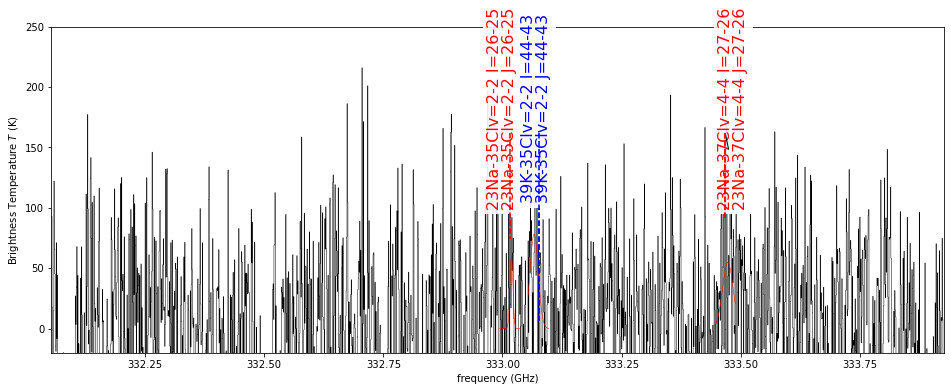

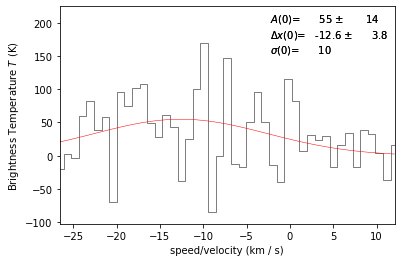

In [17]:
%run -i /orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis/line_fits.py

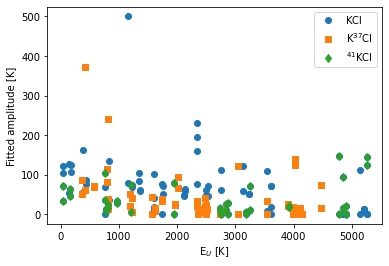

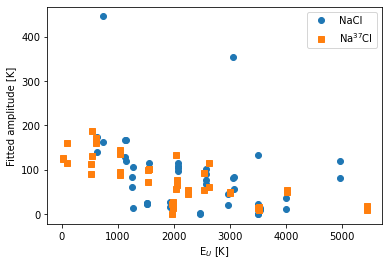

In [18]:
# plot some things....

pl.figure(1).clf()

kclmask = np.array(['K-35Cl' in row['Species'] for row in tbl1])
k41clmask = np.array(['41K-35Cl' in row['Species'] for row in tbl1])
k37clmask = np.array(['K-37Cl' in row['Species'] for row in tbl1])
pl.plot(tbl1['EU_K'][kclmask], tbl1['Fitted Amplitude K'][kclmask], 'o', label='KCl')
pl.plot(tbl1['EU_K'][k37clmask], tbl1['Fitted Amplitude K'][k37clmask], 's', label='K$^{37}$Cl')
pl.plot(tbl1['EU_K'][k41clmask], tbl1['Fitted Amplitude K'][k41clmask], 'd', label='$^{41}$KCl')
pl.xlabel("E$_U$ [K]")
pl.ylabel("Fitted amplitude [K]")
pl.legend(loc='best')
pl.savefig(paths.fpath('corners_KCl_amp_vs_eu.pdf'))

pl.figure(2).clf()
naclmask = np.array(['Na-35Cl' in row['Species'] for row in tbl1])
na37clmask = np.array(['Na-37Cl' in row['Species'] for row in tbl1])
pl.plot(tbl1['EU_K'][naclmask], tbl1['Fitted Amplitude K'][naclmask], 'o', label='NaCl')
pl.plot(tbl1['EU_K'][na37clmask], tbl1['Fitted Amplitude K'][na37clmask], 's', label='Na$^{37}$Cl')
pl.xlabel("E$_U$ [K]")
pl.ylabel("Fitted amplitude [K]")
pl.legend(loc='best')
pl.savefig(paths.fpath('corners_NaCl_amp_vs_eu.pdf'))


In [19]:
tbl1

Line Name,Species,QNs,v,J$_u$,J$_l$,Frequency,Fitted Velocity,Fitted Velocity error,Fitted Width,Fitted Width error,Fitted Amplitude K,Fitted Amplitude error K,Integrated Intensity,Integrated Intensity error,Jy/K,EU_K,deg,Aij,Flag,Corner
,,,,,,GHz,km / s,km / s,km / s,km / s,K,K,K km / s,K km / s,K,K,,,,
str25,str23,str15,str21,str21,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str2,str10
23Na-37Clv=5-5 J=71-70,23Na-35Clv=1-1 J=18-17,v=1-1 J=18-17,1,18,17,232.50997700000002,18.584482828137993,0.39242962477471394,4.5179862095166365,505.9890492124883,139.54807998340146,10.497198360899494,1580.369722394729,70609.81623750836,15424.753223047466,625.7,592,0.005799999926239252,-d,topright
23Na-37Clv=5-5 J=71-70,23Na-35Clv=1-1 J=18-17,v=1-1 J=18-17,1,18,17,232.50997700000002,-7.85715892197685,0.2007623281166518,2.7314730414439135,258.85784378722855,174.67497791557702,11.118530861316987,1195.9624653248363,45215.99834601906,15424.753223047466,625.7,592,0.005799999926239252,-d,bottomleft
41K-37Clv=9-9 J=128-127,23Na-35Clv=1-1 J=26-25,v=1-1 J=26-25,1,26,25,335.506563,17.757342301222224,0.31638893729432815,0.6105186118501016,287.89929655607176,161.51242968973813,72.1036358757138,247.16945085763822,46499.33572975234,18346.11307871118,737.2,848,0.017999999225139618,-d,topright
41K-37Clv=9-9 J=128-127,23Na-35Clv=1-1 J=26-25,v=1-1 J=26-25,1,26,25,335.506563,-5.107847127855931,134363.32084312206,0.20058038479531734,378796589.6176161,445.3234750710014,4409553235.621097,223.89994336586386,168689332370.44424,18346.11307871118,737.2,848,0.017999999225139618,-d,bottomleft
39K-35Clv=6-6 J=119-118,23Na-35Clv=1-1 J=67-66,v=1-1 J=67-66,1,67,66,855.044806,11.641996108924817,0.5717922641497329,2.8468310521818707,200.4795825559673,26.18801540291387,4.555116657382651,186.87629541048915,5250.178410652555,204.5534199551512,1923.9,2160,0.30000001192092896,--,topright
39K-35Clv=6-6 J=119-118,23Na-35Clv=1-1 J=67-66,v=1-1 J=67-66,1,67,66,855.044806,-2.5898751328522893,1.9825989840926088,10.0,0.0,15.913244984694524,2.126906514455866,398.8858981976525,21.26906514455866,204.5534199551512,1923.9,2160,0.30000001192092896,--,bottomleft
39K-37Clv=9-9 J=125-124,23Na-35Clv=2-2 J=17-16,v=2-2 J=17-16,2,17,16,217.980231,18.181899611723537,0.3111819086578002,3.9467980082288,427.9745424916523,129.5111242766477,8.843178589430416,1281.2736890765266,55427.47514871008,2195.913917800106,1128.4,560,0.004900000058114529,-d,topright
39K-37Clv=9-9 J=125-124,23Na-35Clv=2-2 J=17-16,v=2-2 J=17-16,2,17,16,217.980231,-7.897521899244419,0.1713828331807574,2.363821254360092,235.70614898674367,167.36452120139467,10.508610159124967,991.6718078704704,39448.85459026836,2195.913917800106,1128.4,560,0.004900000058114529,-d,bottomleft


In [20]:
tbl1[naclmask]

Line Name,Species,QNs,v,J$_u$,J$_l$,Frequency,Fitted Velocity,Fitted Velocity error,Fitted Width,Fitted Width error,Fitted Amplitude K,Fitted Amplitude error K,Integrated Intensity,Integrated Intensity error,Jy/K,EU_K,deg,Aij,Flag,Corner
,,,,,,GHz,km / s,km / s,km / s,km / s,K,K,K km / s,K km / s,K,K,,,,
str25,str23,str15,str21,str21,str21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str2,str10
23Na-37Clv=5-5 J=71-70,23Na-35Clv=1-1 J=18-17,v=1-1 J=18-17,1,18,17,232.50997700000002,18.584482828137993,0.39242962477471394,4.5179862095166365,505.9890492124883,139.54807998340146,10.497198360899494,1580.369722394729,70609.81623750836,15424.753223047466,625.7,592,0.005799999926239252,-d,topright
23Na-37Clv=5-5 J=71-70,23Na-35Clv=1-1 J=18-17,v=1-1 J=18-17,1,18,17,232.50997700000002,-7.85715892197685,0.2007623281166518,2.7314730414439135,258.85784378722855,174.67497791557702,11.118530861316987,1195.9624653248363,45215.99834601906,15424.753223047466,625.7,592,0.005799999926239252,-d,bottomleft
41K-37Clv=9-9 J=128-127,23Na-35Clv=1-1 J=26-25,v=1-1 J=26-25,1,26,25,335.506563,17.757342301222224,0.31638893729432815,0.6105186118501016,287.89929655607176,161.51242968973813,72.1036358757138,247.16945085763822,46499.33572975234,18346.11307871118,737.2,848,0.017999999225139618,-d,topright
41K-37Clv=9-9 J=128-127,23Na-35Clv=1-1 J=26-25,v=1-1 J=26-25,1,26,25,335.506563,-5.107847127855931,134363.32084312206,0.20058038479531734,378796589.6176161,445.3234750710014,4409553235.621097,223.89994336586386,168689332370.44424,18346.11307871118,737.2,848,0.017999999225139618,-d,bottomleft
39K-35Clv=6-6 J=119-118,23Na-35Clv=1-1 J=67-66,v=1-1 J=67-66,1,67,66,855.044806,11.641996108924817,0.5717922641497329,2.8468310521818707,200.4795825559673,26.18801540291387,4.555116657382651,186.87629541048915,5250.178410652555,204.5534199551512,1923.9,2160,0.30000001192092896,--,topright
39K-35Clv=6-6 J=119-118,23Na-35Clv=1-1 J=67-66,v=1-1 J=67-66,1,67,66,855.044806,-2.5898751328522893,1.9825989840926088,10.0,0.0,15.913244984694524,2.126906514455866,398.8858981976525,21.26906514455866,204.5534199551512,1923.9,2160,0.30000001192092896,--,bottomleft
39K-37Clv=9-9 J=125-124,23Na-35Clv=2-2 J=17-16,v=2-2 J=17-16,2,17,16,217.980231,18.181899611723537,0.3111819086578002,3.9467980082288,427.9745424916523,129.5111242766477,8.843178589430416,1281.2736890765266,55427.47514871008,2195.913917800106,1128.4,560,0.004900000058114529,-d,topright
39K-37Clv=9-9 J=125-124,23Na-35Clv=2-2 J=17-16,v=2-2 J=17-16,2,17,16,217.980231,-7.897521899244419,0.1713828331807574,2.363821254360092,235.70614898674367,167.36452120139467,10.508610159124967,991.6718078704704,39448.85459026836,2195.913917800106,1128.4,560,0.004900000058114529,-d,bottomleft


In [21]:
cornertbl = Table.read(paths.tpath('corner_line_fits.txt'), format='ascii.fixed_width')
cornertbl

Line Name,v,J$_u$,J$_l$,Frequency,Fitted Velocity,Fitted Velocity error,Fitted Width,Fitted Width error,Fitted Amplitude K,Fitted Amplitude error K,Integrated Intensity,Integrated Intensity error,EU_K,Flag,Corner
str25,str4,str3,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,str10
39K-35Clv=7-7 J=117-116,5,7,6,85.981669,19.046874577434828,0.6639068696636886,2.8493346448197068,2246.623454128195,93.26056676622794,18.49197658480932,666.0877448616005,209521.383267439,2538.2,-d,topright
39K-35Clv=7-7 J=117-116,5,7,6,85.981669,-9.513139906523481,3.4133269397470984,10.0,0.0,53.536137306195215,12.629558446750943,1341.9519548623643,126.29558446750943,2538.2,-d,bottomleft
39K-37Clv=9-9 J=122-121,4,7,6,86.62108500000001,-8.871477212601047,1.702912927744132,2.8336779009247963,5728.642849022033,55.80678723742968,28.565291004537055,396.3943344315142,319697.16288189683,2043.6,-d,bottomleft
39K-37Clv=9-9 J=122-121,4,7,6,86.62108500000001,24.48280635580088,0.5616988022742446,4.2924660424153736,1943.9608717782637,133.93278008360716,15.177727583315068,1441.0653839364406,260360.09208223963,2043.6,-d,topright
23Na-35Clv=6-6 J=7-6,6,7,6,87.169205,19.921566728716,0.6067526175626992,1.732446537420379,8431.049686481276,80.64882149475424,108.97809126391125,350.22552988123806,679954.2473897224,3060.0,-d,topright
23Na-35Clv=6-6 J=7-6,6,7,6,87.169205,-10.196390094375769,59358.00885421362,0.7917637792278122,2521248409.407417,354.8589663717887,1473885087.9429615,704.273500479027,894688365585.3496,3060.0,-d,bottomleft
23Na-35Clv=2-2 J=39-38,3,7,6,87.264636,21.033270257921078,0.6073249519590354,2.6078870294519136,1839.3931252397904,98.84789993057683,18.48997312666863,646.1690544760477,181820.15397077426,1544.3,-d,topright
23Na-35Clv=2-2 J=39-38,3,7,6,87.264636,-8.230176438800711,3.7751653596416364,1.5078851722276325,19013.62710180957,71.28788440574445,296.7372071414251,269.4473590182884,1355441.3248210198,1544.3,-d,bottomleft
39K-37Clv=0-0 J=118-117,5,7,6,87.82519,-8.005670789851164,0.7359382293817014,2.9276155021739174,2601.944450186565,66.74835583213871,14.806103405520698,489.8290576826219,173675.51942581098,2565.2,-d,bottomleft


In [22]:
paths.fpath('spectral_fits')

'/orange/adamginsburg/orion/2016.1.00165.S/figures/spectral_fits'

In [23]:
vwidth

<Quantity 10. km / s>

In [24]:
row['Frequency']

841.2871671555833

In [25]:
paths.fpath('spectral_fits')

'/orange/adamginsburg/orion/2016.1.00165.S/figures/spectral_fits'

In [26]:
mkdir /orange/adamginsburg/orion/2016.1.00165.S/figures/spectral_fits

mkdir: cannot create directory ‘/orange/adamginsburg/orion/2016.1.00165.S/figures/spectral_fits’: File exists


In [27]:
xx,yy

(53, 42)

In [28]:
paths.dpath('')

'/orange/adamginsburg/orion/2016.1.00165.S/FITS/'

In [29]:
spwband = {spw: {band: f'{epath}/OrionSourceI_only.{band}.robust0.5.spw{spw}.*clarkclean10000_medsub.image.pbcor.fits'
    for band in ('B3', 'B6', 'B7.lb')}
    for spw in (0,1,2,3)}


In [30]:
spwband

{0: {'B3': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B3.robust0.5.spw0.*clarkclean10000_medsub.image.pbcor.fits',
  'B6': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B6.robust0.5.spw0.*clarkclean10000_medsub.image.pbcor.fits',
  'B7.lb': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B7.lb.robust0.5.spw0.*clarkclean10000_medsub.image.pbcor.fits'},
 1: {'B3': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B3.robust0.5.spw1.*clarkclean10000_medsub.image.pbcor.fits',
  'B6': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B6.robust0.5.spw1.*clarkclean10000_medsub.image.pbcor.fits',
  'B7.lb': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B7.lb.robust0.5.spw1.*clarkclean10000_medsub.image.pbcor.fits'},
 2: {'B3': '/orange/adamginsburg/orion/2016.1.00165.S/external//OrionSourceI_only.B3.robust0.5.spw2.*clarkclean10000_medsub.image.pbcor.fits